In [1]:
import sys
sys.path.append('../code')
from resnet import *
from cifar_very_tiny import *
from cifar_dataset import *    
import torch as t 
import numpy as np
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import hyperparams
from importlib import reload

%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

In [2]:
# добавил в загрузку валидационную выборку
# обрати внимание, maxsize --- это размер совокпного обучения и валидации
# поэтому размер обучающей выборки совпадает с тем, что было до этого
_, test_loader, train_loader_no_augumentation, valid_loader = cifar10_loader(batch_size=128, split_train_val=True,
                                                                             maxsize=10112*2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epoch_num = 200
run_num = 5 # количество запусков эксперимента
# версия нужна, чтобы различать старые и новые результаты экспериментов. 
# менять нужно каждый раз, когда есть хотя бы незначительные изменения в эксперименте
experiment_version = '17' 

validate_every_epoch = 5 # каждые 5 эпох отслеживать параметры модели

# с этими гиперпараметрами мы начинаем эксперименты
start_beta = 0.9914 #0.3 
start_temp  = 6.5 #10**(0.5)

In [4]:
def accuracy(student):
        student.eval()
        total = 0 
        correct = 0
        with t.no_grad():
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)
                out = student(x)
                correct += t.eq(t.argmax(out, 1), y).sum()
                total+=len(x)
        student.train()
        return (correct/total).cpu().detach().numpy()

In [34]:
# запуск без дистилляции
for _ in range(run_num):
    internal_results = []
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())    
    crit = nn.CrossEntropyLoss()
    for e in range(epoch_num):
        tq = tqdm.tqdm(train_loader_no_augumentation)
        losses = []
        for x,y in tq:
            x = x.to(device)
            y = y.to(device)
            student.zero_grad()            
            loss = crit(student(x), y)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))        
        if e==0 or (e+1)%validate_every_epoch == 0: # если номер эпохи делится на 5 или эпоха - первая             
            test_loss = []
            student.eval()
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss.append(crit(student(x), y).detach().cpu().numpy())                 
            test_loss = float(np.mean(test_loss))
            acc = float(accuracy(student))
            student.train()
            internal_results.append({'epoch': e, 'test loss':test_loss, 'accuracy':acc})
            print (internal_results[-1])

    with open('exp'+experiment_version+'_basic.jsonl', 'a') as out:
        out.write(json.dumps({'results':internal_results, 'version': experiment_version})+'\n')

current loss:1.6448382139205933:   5%|▌         | 4/79 [00:00<00:01, 38.85it/s]

{'epoch': 0, 'test loss': 1.6584702730178833, 'accuracy': 0.3919999897480011}


current loss:1.2056939601898193:   5%|▌         | 4/79 [00:00<00:01, 39.17it/s]

{'epoch': 4, 'test loss': 1.3372619152069092, 'accuracy': 0.5212999582290649}


current loss:0.9908003807067871:   5%|▌         | 4/79 [00:00<00:01, 39.09it/s]

{'epoch': 9, 'test loss': 1.3128234148025513, 'accuracy': 0.5396000146865845}


current loss:0.8602039217948914:   5%|▌         | 4/79 [00:00<00:02, 36.37it/s]

{'epoch': 14, 'test loss': 1.348897099494934, 'accuracy': 0.5379999876022339}


current loss:0.7722415328025818:   5%|▌         | 4/79 [00:00<00:01, 37.57it/s]

{'epoch': 19, 'test loss': 1.4245972633361816, 'accuracy': 0.5310999751091003}


current loss:0.7140291333198547:   5%|▌         | 4/79 [00:00<00:01, 37.97it/s]

{'epoch': 24, 'test loss': 1.501477837562561, 'accuracy': 0.5356999635696411}


current loss:0.6453399658203125:   5%|▌         | 4/79 [00:00<00:01, 39.68it/s]

{'epoch': 29, 'test loss': 1.6829416751861572, 'accuracy': 0.5202999711036682}


current loss:0.634465754032135:   5%|▌         | 4/79 [00:00<00:02, 37.34it/s] 

{'epoch': 34, 'test loss': 1.8815585374832153, 'accuracy': 0.4980999827384949}


current loss:0.5239022970199585:   6%|▋         | 5/79 [00:00<00:01, 40.50it/s]

{'epoch': 39, 'test loss': 1.82413649559021, 'accuracy': 0.5178999900817871}


current loss:0.4895573854446411:   6%|▋         | 5/79 [00:00<00:01, 42.02it/s] 

{'epoch': 44, 'test loss': 1.9748332500457764, 'accuracy': 0.5110999941825867}


current loss:0.49121224880218506:   6%|▋         | 5/79 [00:00<00:01, 41.08it/s]

{'epoch': 49, 'test loss': 2.0832743644714355, 'accuracy': 0.5034999847412109}


current loss:0.4265713691711426:   6%|▋         | 5/79 [00:00<00:01, 41.08it/s] 

{'epoch': 54, 'test loss': 2.1079154014587402, 'accuracy': 0.5110999941825867}


current loss:0.3653407096862793:   6%|▋         | 5/79 [00:00<00:01, 40.15it/s] 

{'epoch': 59, 'test loss': 2.1813197135925293, 'accuracy': 0.515500009059906}


current loss:0.31391382217407227:   6%|▋         | 5/79 [00:00<00:01, 42.33it/s]

{'epoch': 64, 'test loss': 2.315239429473877, 'accuracy': 0.5081999897956848}


current loss:0.32999104261398315:   6%|▋         | 5/79 [00:00<00:01, 40.38it/s]

{'epoch': 69, 'test loss': 2.6850669384002686, 'accuracy': 0.4860999882221222}


current loss:0.3718755841255188:   6%|▋         | 5/79 [00:00<00:01, 41.05it/s]

{'epoch': 74, 'test loss': 2.7771055698394775, 'accuracy': 0.4900999963283539}


current loss:0.2700386941432953:   5%|▌         | 4/79 [00:00<00:01, 39.68it/s] 

{'epoch': 79, 'test loss': 2.8410356044769287, 'accuracy': 0.4861999750137329}


current loss:0.23695512115955353:   5%|▌         | 4/79 [00:00<00:01, 39.60it/s]

{'epoch': 84, 'test loss': 3.043401002883911, 'accuracy': 0.4834999740123749}


current loss:0.299189954996109:   6%|▋         | 5/79 [00:00<00:01, 42.41it/s]  

{'epoch': 89, 'test loss': 3.1594529151916504, 'accuracy': 0.484499990940094}


current loss:0.3904634118080139:   6%|▋         | 5/79 [00:00<00:01, 41.97it/s] 

{'epoch': 94, 'test loss': 3.091862201690674, 'accuracy': 0.4748999774456024}


current loss:0.24542051553726196:   6%|▋         | 5/79 [00:00<00:01, 42.89it/s]

{'epoch': 99, 'test loss': 3.254427671432495, 'accuracy': 0.4805999994277954}


current loss:0.20987442135810852:   6%|▋         | 5/79 [00:00<00:01, 40.66it/s]

{'epoch': 104, 'test loss': 3.441070556640625, 'accuracy': 0.482699990272522}


current loss:0.1807553470134735:   6%|▋         | 5/79 [00:00<00:01, 40.46it/s] 

{'epoch': 109, 'test loss': 3.5497162342071533, 'accuracy': 0.4778999984264374}


current loss:0.18955357372760773:   6%|▋         | 5/79 [00:00<00:01, 42.65it/s]

{'epoch': 114, 'test loss': 3.562709093093872, 'accuracy': 0.49709999561309814}


current loss:0.14334748685359955:   6%|▋         | 5/79 [00:00<00:01, 41.02it/s]

{'epoch': 119, 'test loss': 3.7241013050079346, 'accuracy': 0.49300000071525574}


current loss:0.13267076015472412:   6%|▋         | 5/79 [00:00<00:01, 41.61it/s]

{'epoch': 124, 'test loss': 3.972017765045166, 'accuracy': 0.4903999865055084}


current loss:0.14653226733207703:   6%|▋         | 5/79 [00:00<00:01, 40.65it/s]

{'epoch': 129, 'test loss': 4.095426082611084, 'accuracy': 0.4827999770641327}


current loss:0.12188770622015:   5%|▌         | 4/79 [00:00<00:01, 39.98it/s]   

{'epoch': 134, 'test loss': 4.0561113357543945, 'accuracy': 0.4894999861717224}


current loss:0.11077581346035004:   6%|▋         | 5/79 [00:00<00:01, 41.50it/s]

{'epoch': 139, 'test loss': 4.306650161743164, 'accuracy': 0.4919999837875366}


current loss:0.07589338719844818:   6%|▋         | 5/79 [00:00<00:01, 40.36it/s]

{'epoch': 144, 'test loss': 4.343343734741211, 'accuracy': 0.5004000067710876}


current loss:0.07585811614990234:   6%|▋         | 5/79 [00:00<00:01, 42.30it/s]

{'epoch': 149, 'test loss': 4.606943130493164, 'accuracy': 0.482699990272522}


current loss:0.06589322537183762:   6%|▋         | 5/79 [00:00<00:01, 40.71it/s]

{'epoch': 154, 'test loss': 4.563113689422607, 'accuracy': 0.4957999885082245}


current loss:0.07811899483203888:   6%|▋         | 5/79 [00:00<00:01, 42.55it/s]

{'epoch': 159, 'test loss': 4.71195125579834, 'accuracy': 0.49559998512268066}


current loss:0.07643891870975494:   6%|▋         | 5/79 [00:00<00:01, 42.10it/s]

{'epoch': 164, 'test loss': 4.893531322479248, 'accuracy': 0.48729997873306274}


current loss:0.07731877267360687:   6%|▋         | 5/79 [00:00<00:01, 41.31it/s]

{'epoch': 169, 'test loss': 4.870872974395752, 'accuracy': 0.498199999332428}


current loss:0.0904965028166771:   6%|▋         | 5/79 [00:00<00:01, 41.21it/s] 

{'epoch': 174, 'test loss': 5.000840187072754, 'accuracy': 0.49570000171661377}


current loss:0.0965837687253952:   6%|▋         | 5/79 [00:00<00:01, 40.55it/s] 

{'epoch': 179, 'test loss': 5.0914506912231445, 'accuracy': 0.49059998989105225}


current loss:0.06831595301628113:   6%|▋         | 5/79 [00:00<00:01, 42.02it/s]

{'epoch': 184, 'test loss': 5.223604202270508, 'accuracy': 0.4950999915599823}


current loss:0.08001230657100677:   6%|▋         | 5/79 [00:00<00:01, 41.73it/s]

{'epoch': 189, 'test loss': 5.437564849853516, 'accuracy': 0.48889997601509094}


current loss:0.06012019142508507:   6%|▋         | 5/79 [00:00<00:01, 41.56it/s] 

{'epoch': 194, 'test loss': 5.4446563720703125, 'accuracy': 0.49379998445510864}


current loss:2.2720932960510254:   5%|▌         | 4/79 [00:00<00:01, 39.57it/s]

{'epoch': 199, 'test loss': 5.588682651519775, 'accuracy': 0.4827999770641327}


current loss:1.6321022510528564:   6%|▋         | 5/79 [00:00<00:01, 42.76it/s]

{'epoch': 0, 'test loss': 1.6633325815200806, 'accuracy': 0.3969999849796295}


current loss:1.2064495086669922:   5%|▌         | 4/79 [00:00<00:01, 39.80it/s]

{'epoch': 4, 'test loss': 1.386938452720642, 'accuracy': 0.5029999613761902}


current loss:0.973526120185852:   6%|▋         | 5/79 [00:00<00:01, 40.60it/s] 

{'epoch': 9, 'test loss': 1.3712364435195923, 'accuracy': 0.5286999940872192}


current loss:0.8716588616371155:   5%|▌         | 4/79 [00:00<00:02, 36.55it/s]

{'epoch': 14, 'test loss': 1.4516962766647339, 'accuracy': 0.5288000106811523}


current loss:0.8033321499824524:   5%|▌         | 4/79 [00:00<00:01, 38.33it/s]

{'epoch': 19, 'test loss': 1.5376415252685547, 'accuracy': 0.5206999778747559}


current loss:0.7461151480674744:   5%|▌         | 4/79 [00:00<00:01, 38.96it/s]

{'epoch': 24, 'test loss': 1.531410813331604, 'accuracy': 0.5263999700546265}


current loss:0.6755725145339966:   5%|▌         | 4/79 [00:00<00:01, 39.65it/s]

{'epoch': 29, 'test loss': 1.6020809412002563, 'accuracy': 0.5281000137329102}


current loss:0.6058791875839233:   5%|▌         | 4/79 [00:00<00:01, 39.41it/s]

{'epoch': 34, 'test loss': 1.6901073455810547, 'accuracy': 0.5331999659538269}


current loss:0.5656920671463013:   6%|▋         | 5/79 [00:00<00:01, 40.98it/s]

{'epoch': 39, 'test loss': 1.8474576473236084, 'accuracy': 0.5307999849319458}


current loss:0.534543514251709:   6%|▋         | 5/79 [00:00<00:01, 40.64it/s] 

{'epoch': 44, 'test loss': 1.9657946825027466, 'accuracy': 0.5184999704360962}


current loss:0.5149695873260498:   6%|▋         | 5/79 [00:00<00:01, 40.65it/s]

{'epoch': 49, 'test loss': 2.037297487258911, 'accuracy': 0.5194000005722046}


current loss:0.43743380904197693:   6%|▋         | 5/79 [00:00<00:01, 40.89it/s]

{'epoch': 54, 'test loss': 2.1425256729125977, 'accuracy': 0.5169999599456787}


current loss:0.40420255064964294:   6%|▋         | 5/79 [00:00<00:01, 41.03it/s]

{'epoch': 59, 'test loss': 2.3187949657440186, 'accuracy': 0.508899986743927}


current loss:0.38344502449035645:   5%|▌         | 4/79 [00:00<00:01, 39.15it/s]

{'epoch': 64, 'test loss': 2.4573557376861572, 'accuracy': 0.50409996509552}


current loss:0.3904760181903839:   6%|▋         | 5/79 [00:00<00:01, 40.74it/s] 

{'epoch': 69, 'test loss': 2.9025685787200928, 'accuracy': 0.493399977684021}


current loss:0.3694646954536438:   5%|▌         | 4/79 [00:00<00:01, 39.30it/s] 

{'epoch': 74, 'test loss': 2.6607627868652344, 'accuracy': 0.5036999583244324}


current loss:0.34827524423599243:   6%|▋         | 5/79 [00:00<00:01, 40.30it/s]

{'epoch': 79, 'test loss': 2.663698434829712, 'accuracy': 0.5074999928474426}


current loss:0.35609865188598633:   5%|▌         | 4/79 [00:00<00:01, 39.79it/s]

{'epoch': 84, 'test loss': 2.8226065635681152, 'accuracy': 0.49379998445510864}


current loss:0.30817198753356934:   6%|▋         | 5/79 [00:00<00:01, 40.44it/s]

{'epoch': 89, 'test loss': 3.0137414932250977, 'accuracy': 0.4903999865055084}


current loss:0.28894343972206116:   6%|▋         | 5/79 [00:00<00:01, 40.90it/s]

{'epoch': 94, 'test loss': 3.184377670288086, 'accuracy': 0.4887000024318695}


current loss:0.26553088426589966:   6%|▋         | 5/79 [00:00<00:01, 40.87it/s]

{'epoch': 99, 'test loss': 3.174610137939453, 'accuracy': 0.49570000171661377}


current loss:0.2576744556427002:   6%|▋         | 5/79 [00:00<00:01, 42.01it/s] 

{'epoch': 104, 'test loss': 3.315504550933838, 'accuracy': 0.4964999854564667}


current loss:0.24359814822673798:   6%|▋         | 5/79 [00:00<00:01, 42.12it/s]

{'epoch': 109, 'test loss': 3.463222026824951, 'accuracy': 0.4936999976634979}


current loss:0.2131386697292328:   6%|▋         | 5/79 [00:00<00:01, 40.06it/s] 

{'epoch': 114, 'test loss': 3.5130865573883057, 'accuracy': 0.4925999939441681}


current loss:0.1804109513759613:   6%|▋         | 5/79 [00:00<00:01, 40.30it/s] 

{'epoch': 119, 'test loss': 3.718689441680908, 'accuracy': 0.4878000020980835}


current loss:0.1979374885559082:   5%|▌         | 4/79 [00:00<00:01, 39.59it/s] 

{'epoch': 124, 'test loss': 3.6432437896728516, 'accuracy': 0.49779999256134033}


current loss:0.16389405727386475:   6%|▋         | 5/79 [00:00<00:01, 40.46it/s]

{'epoch': 129, 'test loss': 3.7578835487365723, 'accuracy': 0.4998999834060669}


current loss:0.12391018867492676:   6%|▋         | 5/79 [00:00<00:01, 40.72it/s]

{'epoch': 134, 'test loss': 3.9728119373321533, 'accuracy': 0.499099999666214}


current loss:0.12251514941453934:   6%|▋         | 5/79 [00:00<00:01, 41.38it/s]

{'epoch': 139, 'test loss': 4.116206169128418, 'accuracy': 0.4991999864578247}


current loss:0.09698463976383209:   6%|▋         | 5/79 [00:00<00:01, 40.33it/s]

{'epoch': 144, 'test loss': 4.296867847442627, 'accuracy': 0.49639999866485596}


current loss:0.11917072534561157:   6%|▋         | 5/79 [00:00<00:01, 42.23it/s]

{'epoch': 149, 'test loss': 4.4023118019104, 'accuracy': 0.5011000037193298}


current loss:0.12300443649291992:   5%|▌         | 4/79 [00:00<00:02, 33.83it/s]

{'epoch': 154, 'test loss': 4.628902912139893, 'accuracy': 0.4921000003814697}


current loss:0.13223159313201904:   5%|▌         | 4/79 [00:00<00:01, 38.46it/s]

{'epoch': 159, 'test loss': 4.93950891494751, 'accuracy': 0.484499990940094}


current loss:0.1362534910440445:   6%|▋         | 5/79 [00:00<00:01, 39.96it/s] 

{'epoch': 164, 'test loss': 4.8436503410339355, 'accuracy': 0.48569998145103455}


current loss:0.11786340177059174:   6%|▋         | 5/79 [00:00<00:01, 42.02it/s]

{'epoch': 169, 'test loss': 4.868894100189209, 'accuracy': 0.48749998211860657}


current loss:0.07379642874002457:   5%|▌         | 4/79 [00:00<00:01, 38.92it/s]

{'epoch': 174, 'test loss': 4.982524871826172, 'accuracy': 0.48729997873306274}


current loss:0.05328270420432091:   5%|▌         | 4/79 [00:00<00:01, 39.12it/s]

{'epoch': 179, 'test loss': 4.997908592224121, 'accuracy': 0.49719998240470886}


current loss:0.08639650791883469:   6%|▋         | 5/79 [00:00<00:01, 40.70it/s]

{'epoch': 184, 'test loss': 5.500466823577881, 'accuracy': 0.48479998111724854}


current loss:0.046658705919981:   6%|▋         | 5/79 [00:00<00:01, 41.71it/s]   

{'epoch': 189, 'test loss': 5.2601542472839355, 'accuracy': 0.4883999824523926}


current loss:0.07424011826515198:   5%|▌         | 4/79 [00:00<00:01, 39.89it/s] 

{'epoch': 194, 'test loss': 5.524256229400635, 'accuracy': 0.48919999599456787}


current loss:2.3084216117858887:   6%|▋         | 5/79 [00:00<00:01, 40.46it/s]

{'epoch': 199, 'test loss': 5.555168628692627, 'accuracy': 0.4867999851703644}


current loss:1.590518593788147:   5%|▌         | 4/79 [00:00<00:01, 38.42it/s] 

{'epoch': 0, 'test loss': 1.6320834159851074, 'accuracy': 0.41110000014305115}


current loss:1.1428501605987549:   5%|▌         | 4/79 [00:00<00:01, 39.50it/s]

{'epoch': 4, 'test loss': 1.3181078433990479, 'accuracy': 0.530299961566925}


current loss:0.9506807327270508:   6%|▋         | 5/79 [00:00<00:01, 40.74it/s]

{'epoch': 9, 'test loss': 1.347411870956421, 'accuracy': 0.5327000021934509}


current loss:0.8060052990913391:   6%|▋         | 5/79 [00:00<00:01, 41.98it/s]

{'epoch': 14, 'test loss': 1.3777105808258057, 'accuracy': 0.5393999814987183}


current loss:0.7004863023757935:   5%|▌         | 4/79 [00:00<00:01, 38.88it/s]

{'epoch': 19, 'test loss': 1.445442795753479, 'accuracy': 0.5425999760627747}


current loss:0.6335444450378418:   6%|▋         | 5/79 [00:00<00:01, 40.34it/s]

{'epoch': 24, 'test loss': 1.515289545059204, 'accuracy': 0.5428000092506409}


current loss:0.6016579270362854:   5%|▌         | 4/79 [00:00<00:01, 39.89it/s]

{'epoch': 29, 'test loss': 1.645145058631897, 'accuracy': 0.525600016117096}


current loss:0.5718364119529724:   6%|▋         | 5/79 [00:00<00:01, 41.00it/s]

{'epoch': 34, 'test loss': 1.7737977504730225, 'accuracy': 0.5169999599456787}


current loss:0.5568210482597351:   6%|▋         | 5/79 [00:00<00:01, 39.56it/s]

{'epoch': 39, 'test loss': 1.8525134325027466, 'accuracy': 0.510699987411499}


current loss:0.48317334055900574:   6%|▋         | 5/79 [00:00<00:01, 40.05it/s]

{'epoch': 44, 'test loss': 1.8715039491653442, 'accuracy': 0.5199999809265137}


current loss:0.41166412830352783:   6%|▋         | 5/79 [00:00<00:01, 40.69it/s]

{'epoch': 49, 'test loss': 1.9955350160598755, 'accuracy': 0.526699960231781}


current loss:0.37366488575935364:   5%|▌         | 4/79 [00:00<00:01, 39.90it/s]

{'epoch': 54, 'test loss': 2.148554801940918, 'accuracy': 0.51910001039505}


current loss:0.3369571566581726:   6%|▋         | 5/79 [00:00<00:01, 40.26it/s]

{'epoch': 59, 'test loss': 2.324099540710449, 'accuracy': 0.5200999975204468}


current loss:0.32342198491096497:   6%|▋         | 5/79 [00:00<00:01, 41.60it/s]

{'epoch': 64, 'test loss': 2.543182611465454, 'accuracy': 0.5144999623298645}


current loss:0.32886356115341187:   6%|▋         | 5/79 [00:00<00:01, 41.52it/s]

{'epoch': 69, 'test loss': 2.7279109954833984, 'accuracy': 0.5051000118255615}


current loss:0.38990312814712524:   6%|▋         | 5/79 [00:00<00:01, 40.20it/s]

{'epoch': 74, 'test loss': 2.9184963703155518, 'accuracy': 0.4916999936103821}


current loss:0.34324437379837036:   6%|▋         | 5/79 [00:00<00:01, 40.54it/s]

{'epoch': 79, 'test loss': 2.8410961627960205, 'accuracy': 0.5020999908447266}


current loss:0.3173424005508423:   6%|▋         | 5/79 [00:00<00:01, 40.09it/s] 

{'epoch': 84, 'test loss': 3.092689275741577, 'accuracy': 0.4827999770641327}


current loss:0.25705042481422424:   6%|▋         | 5/79 [00:00<00:01, 41.52it/s]

{'epoch': 89, 'test loss': 3.1304562091827393, 'accuracy': 0.4870999753475189}


current loss:0.21318785846233368:   6%|▋         | 5/79 [00:00<00:01, 40.05it/s]

{'epoch': 94, 'test loss': 3.2619168758392334, 'accuracy': 0.48899999260902405}


current loss:0.21197044849395752:   5%|▌         | 4/79 [00:00<00:01, 39.80it/s]

{'epoch': 99, 'test loss': 3.439574718475342, 'accuracy': 0.4869999885559082}


current loss:0.2158963531255722:   6%|▋         | 5/79 [00:00<00:01, 41.79it/s] 

{'epoch': 104, 'test loss': 3.5275466442108154, 'accuracy': 0.49629998207092285}


current loss:0.2062608003616333:   6%|▋         | 5/79 [00:00<00:01, 40.39it/s] 

{'epoch': 109, 'test loss': 3.539674758911133, 'accuracy': 0.5013999938964844}


current loss:0.247777059674263:   6%|▋         | 5/79 [00:00<00:01, 41.00it/s]  

{'epoch': 114, 'test loss': 3.677382469177246, 'accuracy': 0.49869999289512634}


current loss:0.2658010423183441:   5%|▌         | 4/79 [00:00<00:01, 38.93it/s] 

{'epoch': 119, 'test loss': 4.206578254699707, 'accuracy': 0.4592999815940857}


current loss:0.20796853303909302:   6%|▋         | 5/79 [00:00<00:01, 40.19it/s]

{'epoch': 124, 'test loss': 3.9679958820343018, 'accuracy': 0.4803999960422516}


current loss:0.16438454389572144:   6%|▋         | 5/79 [00:00<00:01, 41.46it/s]

{'epoch': 129, 'test loss': 3.9061386585235596, 'accuracy': 0.4976999759674072}


current loss:0.13873377442359924:   6%|▋         | 5/79 [00:00<00:01, 40.82it/s]

{'epoch': 134, 'test loss': 4.01660680770874, 'accuracy': 0.5023999810218811}


current loss:0.1173986941576004:   5%|▌         | 4/79 [00:00<00:01, 38.11it/s] 

{'epoch': 139, 'test loss': 4.159336090087891, 'accuracy': 0.5002999901771545}


current loss:0.09377959370613098:   6%|▋         | 5/79 [00:00<00:01, 41.22it/s]

{'epoch': 144, 'test loss': 4.414795875549316, 'accuracy': 0.4984999895095825}


current loss:0.09542496502399445:   6%|▋         | 5/79 [00:00<00:01, 41.41it/s]

{'epoch': 149, 'test loss': 4.4760966300964355, 'accuracy': 0.49949997663497925}


current loss:0.07011410593986511:   6%|▋         | 5/79 [00:00<00:01, 40.88it/s]

{'epoch': 154, 'test loss': 4.671034336090088, 'accuracy': 0.5015999674797058}


current loss:0.07136023044586182:   6%|▋         | 5/79 [00:00<00:01, 41.24it/s]

{'epoch': 159, 'test loss': 4.956066131591797, 'accuracy': 0.494299978017807}


current loss:0.11937535554170609:   6%|▋         | 5/79 [00:00<00:01, 40.23it/s]

{'epoch': 164, 'test loss': 5.3098039627075195, 'accuracy': 0.4794999957084656}


current loss:0.08183879405260086:   6%|▋         | 5/79 [00:00<00:01, 41.34it/s]

{'epoch': 169, 'test loss': 4.871285915374756, 'accuracy': 0.49969998002052307}


current loss:0.053309518843889236:   6%|▋         | 5/79 [00:00<00:01, 41.66it/s]

{'epoch': 174, 'test loss': 5.123619556427002, 'accuracy': 0.4982999861240387}


current loss:0.042216069996356964:   5%|▌         | 4/79 [00:00<00:01, 39.25it/s]

{'epoch': 179, 'test loss': 5.254069805145264, 'accuracy': 0.5038999915122986}


current loss:0.03491443395614624:   6%|▋         | 5/79 [00:00<00:01, 40.32it/s] 

{'epoch': 184, 'test loss': 5.3951544761657715, 'accuracy': 0.49779999256134033}


current loss:0.060639847069978714:   5%|▌         | 4/79 [00:00<00:01, 39.83it/s]

{'epoch': 189, 'test loss': 5.539305686950684, 'accuracy': 0.5011000037193298}


current loss:0.06660845875740051:   5%|▌         | 4/79 [00:00<00:01, 39.54it/s]

{'epoch': 194, 'test loss': 5.520047664642334, 'accuracy': 0.4998999834060669}


current loss:2.276418924331665:   6%|▋         | 5/79 [00:00<00:01, 41.97it/s] 

{'epoch': 199, 'test loss': 5.597874164581299, 'accuracy': 0.5031999945640564}


current loss:1.6036314964294434:   6%|▋         | 5/79 [00:00<00:01, 40.36it/s]

{'epoch': 0, 'test loss': 1.652007818222046, 'accuracy': 0.40119999647140503}


current loss:1.1984248161315918:   6%|▋         | 5/79 [00:00<00:01, 40.77it/s]

{'epoch': 4, 'test loss': 1.3504860401153564, 'accuracy': 0.5120999813079834}


current loss:0.9986315965652466:   6%|▋         | 5/79 [00:00<00:01, 41.33it/s]

{'epoch': 9, 'test loss': 1.3220850229263306, 'accuracy': 0.5336999893188477}


current loss:0.8660963177680969:   6%|▋         | 5/79 [00:00<00:01, 42.02it/s]

{'epoch': 14, 'test loss': 1.3743840456008911, 'accuracy': 0.5378000140190125}


current loss:0.8009462356567383:   5%|▌         | 4/79 [00:00<00:01, 37.81it/s]

{'epoch': 19, 'test loss': 1.491887092590332, 'accuracy': 0.5200999975204468}


current loss:0.7072457075119019:   5%|▌         | 4/79 [00:00<00:01, 39.96it/s]

{'epoch': 24, 'test loss': 1.551611065864563, 'accuracy': 0.5235999822616577}


current loss:0.6266094446182251:   6%|▋         | 5/79 [00:00<00:01, 41.27it/s]

{'epoch': 29, 'test loss': 1.5886008739471436, 'accuracy': 0.5230000019073486}


current loss:0.6145144701004028:   5%|▌         | 4/79 [00:00<00:01, 38.88it/s]

{'epoch': 34, 'test loss': 1.6700935363769531, 'accuracy': 0.5270000100135803}


current loss:0.5673044323921204:   5%|▌         | 4/79 [00:00<00:01, 38.76it/s]

{'epoch': 39, 'test loss': 1.7885311841964722, 'accuracy': 0.5180999636650085}


current loss:0.5195380449295044:   5%|▌         | 4/79 [00:00<00:01, 39.40it/s] 

{'epoch': 44, 'test loss': 1.9811089038848877, 'accuracy': 0.5054999589920044}


current loss:0.48392751812934875:   5%|▌         | 4/79 [00:00<00:01, 39.48it/s]

{'epoch': 49, 'test loss': 2.1276252269744873, 'accuracy': 0.4983999729156494}


current loss:0.4511204659938812:   5%|▌         | 4/79 [00:00<00:02, 36.32it/s] 

{'epoch': 54, 'test loss': 2.1663520336151123, 'accuracy': 0.5080000162124634}


current loss:0.45487716794013977:   6%|▋         | 5/79 [00:00<00:01, 40.54it/s]

{'epoch': 59, 'test loss': 2.39863657951355, 'accuracy': 0.4997999966144562}


current loss:0.44927284121513367:   5%|▌         | 4/79 [00:00<00:01, 39.17it/s]

{'epoch': 64, 'test loss': 2.4351024627685547, 'accuracy': 0.4935999810695648}


current loss:0.3797945976257324:   6%|▋         | 5/79 [00:00<00:01, 40.25it/s] 

{'epoch': 69, 'test loss': 2.4668188095092773, 'accuracy': 0.493399977684021}


current loss:0.3259149193763733:   5%|▌         | 4/79 [00:00<00:01, 39.35it/s] 

{'epoch': 74, 'test loss': 2.5122716426849365, 'accuracy': 0.5011999607086182}


current loss:0.28966403007507324:   6%|▋         | 5/79 [00:00<00:01, 41.79it/s]

{'epoch': 79, 'test loss': 2.593844175338745, 'accuracy': 0.5105000138282776}


current loss:0.2752956449985504:   5%|▌         | 4/79 [00:00<00:01, 39.09it/s] 

{'epoch': 84, 'test loss': 2.742384910583496, 'accuracy': 0.5054999589920044}


current loss:0.2668040990829468:   5%|▌         | 4/79 [00:00<00:01, 40.00it/s] 

{'epoch': 89, 'test loss': 2.8583693504333496, 'accuracy': 0.5054999589920044}


current loss:0.25765538215637207:   6%|▋         | 5/79 [00:00<00:01, 40.33it/s]

{'epoch': 94, 'test loss': 2.9194061756134033, 'accuracy': 0.5148000121116638}


current loss:0.2391340732574463:   5%|▌         | 4/79 [00:00<00:01, 38.60it/s] 

{'epoch': 99, 'test loss': 3.1324496269226074, 'accuracy': 0.4966999888420105}


current loss:0.2429163157939911:   5%|▌         | 4/79 [00:00<00:01, 38.95it/s] 

{'epoch': 104, 'test loss': 3.2986550331115723, 'accuracy': 0.4909999966621399}


current loss:0.22611238062381744:   6%|▋         | 5/79 [00:00<00:01, 41.61it/s]

{'epoch': 109, 'test loss': 3.3176324367523193, 'accuracy': 0.505299985408783}


current loss:0.21262449026107788:   6%|▋         | 5/79 [00:00<00:01, 41.13it/s]

{'epoch': 114, 'test loss': 3.3863906860351562, 'accuracy': 0.5029999613761902}


current loss:0.21942956745624542:   6%|▋         | 5/79 [00:00<00:01, 41.59it/s]

{'epoch': 119, 'test loss': 3.4457802772521973, 'accuracy': 0.500499963760376}


current loss:0.21245142817497253:   5%|▌         | 4/79 [00:00<00:01, 38.95it/s]

{'epoch': 124, 'test loss': 3.5703978538513184, 'accuracy': 0.4968999922275543}


current loss:0.16974006593227386:   6%|▋         | 5/79 [00:00<00:01, 41.48it/s]

{'epoch': 129, 'test loss': 3.5316951274871826, 'accuracy': 0.5102999806404114}


current loss:0.15330389142036438:   6%|▋         | 5/79 [00:00<00:01, 40.20it/s]

{'epoch': 134, 'test loss': 3.633881092071533, 'accuracy': 0.5110999941825867}


current loss:0.1314430981874466:   5%|▌         | 4/79 [00:00<00:01, 38.43it/s] 

{'epoch': 139, 'test loss': 3.6954638957977295, 'accuracy': 0.5097000002861023}


current loss:0.1267620325088501:   6%|▋         | 5/79 [00:00<00:01, 40.86it/s] 

{'epoch': 144, 'test loss': 3.8651528358459473, 'accuracy': 0.5157999992370605}


current loss:0.09940172731876373:   5%|▌         | 4/79 [00:00<00:02, 33.86it/s]

{'epoch': 149, 'test loss': 3.888737916946411, 'accuracy': 0.5145999789237976}


current loss:0.07393225282430649:   5%|▌         | 4/79 [00:00<00:01, 37.99it/s]

{'epoch': 154, 'test loss': 4.082302570343018, 'accuracy': 0.5139999985694885}


current loss:0.07053197175264359:   5%|▌         | 4/79 [00:00<00:02, 37.39it/s]

{'epoch': 159, 'test loss': 4.285971641540527, 'accuracy': 0.5099999904632568}


current loss:0.06695704162120819:   5%|▌         | 4/79 [00:00<00:01, 38.90it/s]

{'epoch': 164, 'test loss': 4.546746730804443, 'accuracy': 0.5047000050544739}


current loss:0.10686676949262619:   5%|▌         | 4/79 [00:00<00:01, 39.74it/s]

{'epoch': 169, 'test loss': 4.592453479766846, 'accuracy': 0.5033999681472778}


current loss:0.07031935453414917:   5%|▌         | 4/79 [00:00<00:01, 39.30it/s]

{'epoch': 174, 'test loss': 4.7574782371521, 'accuracy': 0.5029000043869019}


current loss:0.0880700871348381:   6%|▋         | 5/79 [00:00<00:01, 40.41it/s] 

{'epoch': 179, 'test loss': 4.955749988555908, 'accuracy': 0.493399977684021}


current loss:0.07626479119062424:   5%|▌         | 4/79 [00:00<00:02, 37.46it/s]

{'epoch': 184, 'test loss': 5.023365497589111, 'accuracy': 0.5076000094413757}


current loss:0.07831622660160065:   5%|▌         | 4/79 [00:00<00:01, 37.99it/s]

{'epoch': 189, 'test loss': 5.121102333068848, 'accuracy': 0.5008999705314636}


current loss:0.05285116285085678:   5%|▌         | 4/79 [00:00<00:01, 38.97it/s]

{'epoch': 194, 'test loss': 5.221407890319824, 'accuracy': 0.5019999742507935}


current loss:2.289287805557251:   5%|▌         | 4/79 [00:00<00:01, 38.47it/s] 

{'epoch': 199, 'test loss': 5.289700508117676, 'accuracy': 0.49859997630119324}


current loss:1.6444005966186523:   5%|▌         | 4/79 [00:00<00:01, 39.17it/s]

{'epoch': 0, 'test loss': 1.649044156074524, 'accuracy': 0.3862999975681305}


current loss:1.2155306339263916:   5%|▌         | 4/79 [00:00<00:01, 38.47it/s]

{'epoch': 4, 'test loss': 1.3396130800247192, 'accuracy': 0.515999972820282}


current loss:0.9947928190231323:   5%|▌         | 4/79 [00:00<00:01, 38.47it/s]

{'epoch': 9, 'test loss': 1.3039554357528687, 'accuracy': 0.5428999662399292}


current loss:0.8694282174110413:   5%|▌         | 4/79 [00:00<00:01, 38.09it/s]

{'epoch': 14, 'test loss': 1.3395565748214722, 'accuracy': 0.5464999675750732}


current loss:0.7770527005195618:   5%|▌         | 4/79 [00:00<00:02, 37.44it/s]

{'epoch': 19, 'test loss': 1.4004967212677002, 'accuracy': 0.5410999655723572}


current loss:0.7181898951530457:   5%|▌         | 4/79 [00:00<00:01, 38.80it/s]

{'epoch': 24, 'test loss': 1.4565730094909668, 'accuracy': 0.5436999797821045}


current loss:0.6897573471069336:   5%|▌         | 4/79 [00:00<00:01, 38.91it/s]

{'epoch': 29, 'test loss': 1.558390498161316, 'accuracy': 0.5361999869346619}


current loss:0.6218137741088867:   5%|▌         | 4/79 [00:00<00:01, 38.17it/s]

{'epoch': 34, 'test loss': 1.5606861114501953, 'accuracy': 0.538100004196167}


current loss:0.5458524823188782:   6%|▋         | 5/79 [00:00<00:01, 40.41it/s]

{'epoch': 39, 'test loss': 1.7041592597961426, 'accuracy': 0.5317999720573425}


current loss:0.5299654603004456:   5%|▌         | 4/79 [00:00<00:01, 38.52it/s] 

{'epoch': 44, 'test loss': 1.8183510303497314, 'accuracy': 0.5216999650001526}


current loss:0.4871518313884735:   5%|▌         | 4/79 [00:00<00:01, 37.95it/s] 

{'epoch': 49, 'test loss': 1.985124945640564, 'accuracy': 0.519599974155426}


current loss:0.46162915229797363:   5%|▌         | 4/79 [00:00<00:01, 38.25it/s]

{'epoch': 54, 'test loss': 2.1180779933929443, 'accuracy': 0.5137999653816223}


current loss:0.47724229097366333:   5%|▌         | 4/79 [00:00<00:01, 39.33it/s]

{'epoch': 59, 'test loss': 2.2529547214508057, 'accuracy': 0.5062999725341797}


current loss:0.3970804810523987:   5%|▌         | 4/79 [00:00<00:01, 37.72it/s] 

{'epoch': 64, 'test loss': 2.263099193572998, 'accuracy': 0.5036999583244324}


current loss:0.36950406432151794:   5%|▌         | 4/79 [00:00<00:01, 39.16it/s]

{'epoch': 69, 'test loss': 2.446044445037842, 'accuracy': 0.4966000020503998}


current loss:0.3432847559452057:   5%|▌         | 4/79 [00:00<00:01, 39.12it/s] 

{'epoch': 74, 'test loss': 2.521202325820923, 'accuracy': 0.49959999322891235}


current loss:0.3894211947917938:   5%|▌         | 4/79 [00:00<00:01, 37.75it/s] 

{'epoch': 79, 'test loss': 2.7250609397888184, 'accuracy': 0.49289998412132263}


current loss:0.30933165550231934:   5%|▌         | 4/79 [00:00<00:01, 39.96it/s]

{'epoch': 84, 'test loss': 2.6762030124664307, 'accuracy': 0.5048999786376953}


current loss:0.2466765195131302:   5%|▌         | 4/79 [00:00<00:01, 38.96it/s] 

{'epoch': 89, 'test loss': 2.820284605026245, 'accuracy': 0.5008999705314636}


current loss:0.2304336279630661:   5%|▌         | 4/79 [00:00<00:01, 37.95it/s] 

{'epoch': 94, 'test loss': 3.0571751594543457, 'accuracy': 0.49069997668266296}


current loss:0.20707307755947113:   5%|▌         | 4/79 [00:00<00:01, 38.71it/s]

{'epoch': 99, 'test loss': 3.203050136566162, 'accuracy': 0.49570000171661377}


current loss:0.2127637416124344:   5%|▌         | 4/79 [00:00<00:02, 35.74it/s] 

{'epoch': 104, 'test loss': 3.293832540512085, 'accuracy': 0.49799999594688416}


current loss:0.19031241536140442:   5%|▌         | 4/79 [00:00<00:01, 38.39it/s]

{'epoch': 109, 'test loss': 3.410013437271118, 'accuracy': 0.49309998750686646}


current loss:0.2240598499774933:   5%|▌         | 4/79 [00:00<00:01, 38.54it/s] 

{'epoch': 114, 'test loss': 3.55987811088562, 'accuracy': 0.48899999260902405}


current loss:0.19766519963741302:   5%|▌         | 4/79 [00:00<00:01, 39.48it/s]

{'epoch': 119, 'test loss': 3.5571768283843994, 'accuracy': 0.48749998211860657}


current loss:0.27384185791015625:   5%|▌         | 4/79 [00:00<00:01, 38.09it/s]

{'epoch': 124, 'test loss': 3.759361982345581, 'accuracy': 0.47689998149871826}


current loss:0.1450490951538086:   5%|▌         | 4/79 [00:00<00:01, 38.09it/s] 

{'epoch': 129, 'test loss': 3.671895742416382, 'accuracy': 0.493399977684021}


current loss:0.11842512339353561:   5%|▌         | 4/79 [00:00<00:01, 38.17it/s]

{'epoch': 134, 'test loss': 3.9670073986053467, 'accuracy': 0.4925999939441681}


current loss:0.11202434450387955:   5%|▌         | 4/79 [00:00<00:01, 39.49it/s]

{'epoch': 139, 'test loss': 4.156904697418213, 'accuracy': 0.49129998683929443}


current loss:0.10338413715362549:   5%|▌         | 4/79 [00:00<00:02, 37.45it/s]

{'epoch': 144, 'test loss': 4.232254505157471, 'accuracy': 0.49609997868537903}


current loss:0.09249819815158844:   5%|▌         | 4/79 [00:00<00:01, 39.15it/s]

{'epoch': 149, 'test loss': 4.316030979156494, 'accuracy': 0.49309998750686646}


current loss:0.10107983648777008:   5%|▌         | 4/79 [00:00<00:01, 38.53it/s]

{'epoch': 154, 'test loss': 4.425662040710449, 'accuracy': 0.49719998240470886}


current loss:0.10100233554840088:   5%|▌         | 4/79 [00:00<00:01, 39.59it/s]

{'epoch': 159, 'test loss': 4.470008850097656, 'accuracy': 0.49549999833106995}


current loss:0.11437254399061203:   5%|▌         | 4/79 [00:00<00:01, 38.53it/s]

{'epoch': 164, 'test loss': 4.879047393798828, 'accuracy': 0.487199991941452}


current loss:0.07970836013555527:   5%|▌         | 4/79 [00:00<00:01, 37.73it/s]

{'epoch': 169, 'test loss': 4.874513149261475, 'accuracy': 0.49629998207092285}


current loss:0.08344002813100815:   5%|▌         | 4/79 [00:00<00:01, 38.38it/s]

{'epoch': 174, 'test loss': 5.024434566497803, 'accuracy': 0.4932999908924103}


current loss:0.0814441442489624:   5%|▌         | 4/79 [00:00<00:02, 29.19it/s] 

{'epoch': 179, 'test loss': 5.032186031341553, 'accuracy': 0.49719998240470886}


current loss:0.08978623896837234:   5%|▌         | 4/79 [00:00<00:02, 37.20it/s]

{'epoch': 184, 'test loss': 5.142648220062256, 'accuracy': 0.49449998140335083}


current loss:0.07415033131837845:   5%|▌         | 4/79 [00:00<00:01, 37.79it/s] 

{'epoch': 189, 'test loss': 5.2309794425964355, 'accuracy': 0.4919999837875366}


current loss:0.05078067258000374:   5%|▌         | 4/79 [00:00<00:01, 38.63it/s] 

{'epoch': 194, 'test loss': 5.43549108505249, 'accuracy': 0.4885999858379364}


current loss:0.07436975091695786: 100%|██████████| 79/79 [00:02<00:00, 37.17it/s] 


{'epoch': 199, 'test loss': 5.350836753845215, 'accuracy': 0.4916999936103821}


In [5]:
kl = nn.KLDivLoss(reduction='batchmean')
sm = nn.Softmax(dim=1)

def distill(out, batch_logits, temp):
    g = sm(out/temp)
    f = F.log_softmax(batch_logits/temp)    
    return kl(f, g)

In [100]:
# Запуск --- с CNN-дистилляцией
# в качестве значений гиперпараметров ставим  start_beta, start_temp
logits = np.load('./logits_cnn.npy')
for _ in range(run_num):
    internal_results = []
    beta = start_beta
    temp = start_temp
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())   
    crit = nn.CrossEntropyLoss()
    for e in range(epoch_num):
        tq = tqdm.tqdm(train_loader_no_augumentation)
        losses = []
        for batch_id, (x,y) in enumerate(tq):
            x = x.to(device)
            y = y.to(device)            
            batch_logits = t.Tensor(logits[128*batch_id:128*(batch_id+1)]).to(device)            
            student.zero_grad()
            out = student(x)
            student_loss = crit(out, y)            
            distillation_loss = distill(out, batch_logits, temp)
            loss = (1-beta) * student_loss + beta*distillation_loss
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))
        if e==0 or (e+1)%validate_every_epoch == 0: # если номер эпохи делится на 5 или эпоха - первая             
            test_loss = []
            student.eval()
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss.append(crit(student(x), y).detach().cpu().numpy())                 
            test_loss = float(np.mean(test_loss))
            acc = float(accuracy(student))
            student.train()
            internal_results.append({'epoch': e, 'test loss':test_loss, 'accuracy':acc})
            print (internal_results[-1])

            
    with open('exp'+experiment_version+'_distill.jsonl', 'a') as out:
        out.write(json.dumps({'results':internal_results, 'version': experiment_version})+'\n')

  0%|          | 0/79 [00:00<?, ?it/s]<ipython-input-35-cea0592a0b8b>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(batch_logits/temp)
current loss:0.36032313108444214: 100%|██████████| 79/79 [00:02<00:00, 36.78it/s]


KeyboardInterrupt: 

In [8]:
# Запуск --- со случаными значениями гиперпараметров
crit = nn.CrossEntropyLoss()

# определяем функцию потерь как замкнутую относительно аргументов функцию
# нужно для подсчета градиентов гиперпараметров по двухуровневой оптимизации
def param_loss(batch,model,h):
    x,y,batch_logits = batch    
    beta,beta2,temp = h
    out = model(x)
    beta = F.sigmoid(beta)
    beta2 = F.sigmoid(beta2)
    temp = F.sigmoid(temp) * 10
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)                
    loss = beta * distillation_loss + beta2 * student_loss
    return loss

logits = np.load('../code/logits_cnn.npy')
for _ in range(run_num):
    internal_results = []
    
    # теперь beta и temp - не числа, а тензоры, по которым можно считать градиент
    beta1 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1), device=device), requires_grad=True)
    beta2 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1), device=device), requires_grad=True)
    temp = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1), device=device), requires_grad=True)    
    h = [beta1, beta2, temp]
    
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())   
    
 
    
    for e in range(epoch_num): # хочется посмотреть куда сойдутся гиперпараметры, поэтому возьмем побольше эпох
        tq = tqdm.tqdm(train_loader_no_augumentation)
        losses = []
        for batch_id, ((x,y)) in enumerate(tq):
            x = x.to(device)
            y = y.to(device)            
            batch_logits = t.Tensor(logits[128*batch_id:128*(batch_id+1)]).to(device) 
            
            optim.zero_grad()
            loss = param_loss((x,y,batch_logits), student,h)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))
        if e==0 or (e+1)%validate_every_epoch == 0: # если номер эпохи делится на 5 или эпоха - первая             
            test_loss = []
            student.eval()
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss.append(crit(student(x), y).detach().cpu().numpy())                 
            test_loss = float(np.mean(test_loss))
            
            
            acc = float(accuracy(student))
            student.train()
            internal_results.append({'epoch': e, 'test loss':test_loss, 'accuracy':acc, 
                                     'temp':float(10*F.sigmoid(h[2]).cpu().detach().numpy()),
                                     'beta1':float(F.sigmoid(h[0]).cpu().detach().numpy()),
                                     'beta2':float(F.sigmoid(h[1]).cpu().detach().numpy())})
            
            print (internal_results[-1])

            
    with open('exp'+experiment_version+'_dist_h_rand.jsonl', 'a') as out:
        out.write(json.dumps({'results':internal_results, 'version': experiment_version})+'\n')

  0%|          | 0/79 [00:00<?, ?it/s]<ipython-input-5-cea0592a0b8b>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(batch_logits/temp)
current loss:1.9207615852355957:   3%|▎         | 2/79 [00:00<00:03, 19.47it/s]

{'epoch': 0, 'test loss': 1.6431931257247925, 'accuracy': 0.38109999895095825, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:1.359532117843628:   3%|▎         | 2/79 [00:00<00:03, 19.72it/s] 

{'epoch': 4, 'test loss': 1.424196481704712, 'accuracy': 0.5177000164985657, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:1.0528627634048462:   3%|▎         | 2/79 [00:00<00:04, 18.90it/s]

{'epoch': 9, 'test loss': 1.4771891832351685, 'accuracy': 0.550599992275238, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.9309375286102295:   4%|▍         | 3/79 [00:00<00:03, 20.72it/s]

{'epoch': 14, 'test loss': 1.5299255847930908, 'accuracy': 0.5644000172615051, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.8617059588432312:   3%|▎         | 2/79 [00:00<00:03, 19.29it/s]

{'epoch': 19, 'test loss': 1.6782829761505127, 'accuracy': 0.5537999868392944, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.8067569136619568:   3%|▎         | 2/79 [00:00<00:03, 19.60it/s]

{'epoch': 24, 'test loss': 1.776867389678955, 'accuracy': 0.5511000156402588, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.7411576509475708:   3%|▎         | 2/79 [00:00<00:03, 19.35it/s]

{'epoch': 29, 'test loss': 1.8318543434143066, 'accuracy': 0.5605000257492065, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.6858689188957214:   3%|▎         | 2/79 [00:00<00:04, 19.22it/s]

{'epoch': 34, 'test loss': 1.9214941263198853, 'accuracy': 0.5620999932289124, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.6647871732711792:   3%|▎         | 2/79 [00:00<00:03, 19.61it/s]

{'epoch': 39, 'test loss': 2.012333631515503, 'accuracy': 0.5566999912261963, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.6322803497314453:   3%|▎         | 2/79 [00:00<00:03, 19.72it/s]

{'epoch': 44, 'test loss': 2.036475896835327, 'accuracy': 0.555899977684021, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.5887881517410278:   3%|▎         | 2/79 [00:00<00:03, 19.82it/s]

{'epoch': 49, 'test loss': 2.118110179901123, 'accuracy': 0.5514000058174133, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.5619986653327942:   3%|▎         | 2/79 [00:00<00:04, 15.50it/s]

{'epoch': 54, 'test loss': 2.2745752334594727, 'accuracy': 0.5467000007629395, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.5230638384819031:   3%|▎         | 2/79 [00:00<00:03, 19.99it/s]

{'epoch': 59, 'test loss': 2.439298391342163, 'accuracy': 0.5403000116348267, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.5230833292007446:   4%|▍         | 3/79 [00:00<00:03, 20.99it/s]

{'epoch': 64, 'test loss': 2.5571272373199463, 'accuracy': 0.538100004196167, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.5012068152427673:   4%|▍         | 3/79 [00:00<00:03, 20.74it/s]

{'epoch': 69, 'test loss': 2.634535551071167, 'accuracy': 0.541100025177002, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.49765563011169434:   4%|▍         | 3/79 [00:00<00:03, 21.04it/s]

{'epoch': 74, 'test loss': 2.6117334365844727, 'accuracy': 0.5447999835014343, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.4967508912086487:   3%|▎         | 2/79 [00:00<00:03, 19.75it/s]

{'epoch': 79, 'test loss': 2.8077147006988525, 'accuracy': 0.5347999930381775, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.5061660408973694:   3%|▎         | 2/79 [00:00<00:03, 19.67it/s]

{'epoch': 84, 'test loss': 2.9672155380249023, 'accuracy': 0.5284000039100647, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.4532739222049713:   3%|▎         | 2/79 [00:00<00:04, 17.96it/s] 

{'epoch': 89, 'test loss': 2.9920029640197754, 'accuracy': 0.5274999737739563, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.4571312963962555:   3%|▎         | 2/79 [00:00<00:04, 16.28it/s]

{'epoch': 94, 'test loss': 2.9086196422576904, 'accuracy': 0.5358999967575073, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.44905975461006165:   3%|▎         | 2/79 [00:00<00:04, 17.81it/s]

{'epoch': 99, 'test loss': 2.914501905441284, 'accuracy': 0.5410000085830688, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.4366186261177063:   3%|▎         | 2/79 [00:00<00:03, 19.84it/s] 

{'epoch': 104, 'test loss': 3.0227394104003906, 'accuracy': 0.5378999710083008, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.4312112331390381:   4%|▍         | 3/79 [00:00<00:03, 20.98it/s]

{'epoch': 109, 'test loss': 3.2025833129882812, 'accuracy': 0.5267999768257141, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.3746066093444824:   3%|▎         | 2/79 [00:00<00:04, 18.27it/s]

{'epoch': 114, 'test loss': 3.1264870166778564, 'accuracy': 0.5364000201225281, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.3731778562068939:   3%|▎         | 2/79 [00:00<00:03, 19.78it/s] 

{'epoch': 119, 'test loss': 3.169010877609253, 'accuracy': 0.5374000072479248, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.3663356602191925:   4%|▍         | 3/79 [00:00<00:03, 21.86it/s] 

{'epoch': 124, 'test loss': 3.1846930980682373, 'accuracy': 0.5379999876022339, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.3251848816871643:   4%|▍         | 3/79 [00:00<00:03, 22.00it/s]

{'epoch': 129, 'test loss': 3.403904438018799, 'accuracy': 0.5302000045776367, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.3365055024623871:   4%|▍         | 3/79 [00:00<00:03, 22.05it/s]

{'epoch': 134, 'test loss': 3.598224401473999, 'accuracy': 0.521399974822998, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.3235350251197815:   4%|▍         | 3/79 [00:00<00:03, 21.74it/s]

{'epoch': 139, 'test loss': 3.5944788455963135, 'accuracy': 0.5259000062942505, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.3416934311389923:   4%|▍         | 3/79 [00:00<00:03, 21.56it/s] 

{'epoch': 144, 'test loss': 3.814716100692749, 'accuracy': 0.5151000022888184, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.31411266326904297:   4%|▍         | 3/79 [00:00<00:03, 21.93it/s]

{'epoch': 149, 'test loss': 3.638920307159424, 'accuracy': 0.5235999822616577, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.2999296486377716:   3%|▎         | 2/79 [00:00<00:04, 16.91it/s] 

{'epoch': 154, 'test loss': 4.1314873695373535, 'accuracy': 0.5062999725341797, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.30708447098731995:   4%|▍         | 3/79 [00:00<00:03, 21.22it/s]

{'epoch': 159, 'test loss': 3.6683499813079834, 'accuracy': 0.5333999991416931, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.2988862991333008:   4%|▍         | 3/79 [00:00<00:03, 20.64it/s] 

{'epoch': 164, 'test loss': 3.6911544799804688, 'accuracy': 0.5322999954223633, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.29832401871681213:   3%|▎         | 2/79 [00:00<00:03, 19.48it/s]

{'epoch': 169, 'test loss': 3.7836451530456543, 'accuracy': 0.5217000246047974, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.29940924048423767:   4%|▍         | 3/79 [00:00<00:03, 21.35it/s]

{'epoch': 174, 'test loss': 3.771587610244751, 'accuracy': 0.5271999835968018, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.29665565490722656:   4%|▍         | 3/79 [00:00<00:03, 20.78it/s]

{'epoch': 179, 'test loss': 3.7258853912353516, 'accuracy': 0.5321999788284302, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.32873350381851196:   4%|▍         | 3/79 [00:00<00:03, 21.47it/s]

{'epoch': 184, 'test loss': 3.8373122215270996, 'accuracy': 0.526199996471405, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.3364679217338562:   4%|▍         | 3/79 [00:00<00:03, 21.20it/s] 

{'epoch': 189, 'test loss': 3.9863317012786865, 'accuracy': 0.5307000279426575, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:0.3190914988517761:   4%|▍         | 3/79 [00:00<00:03, 21.62it/s] 

{'epoch': 194, 'test loss': 3.991617441177368, 'accuracy': 0.527400016784668, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:2.7690067291259766:   4%|▍         | 3/79 [00:00<00:03, 21.28it/s]

{'epoch': 199, 'test loss': 3.8525514602661133, 'accuracy': 0.5349000096321106, 'temp': 3.0677103996276855, 'beta1': 0.7083740234375, 'beta2': 0.5720742344856262}


current loss:1.9499132633209229:   4%|▍         | 3/79 [00:00<00:03, 21.80it/s]

{'epoch': 0, 'test loss': 1.6366716623306274, 'accuracy': 0.3971000015735626, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:1.4354948997497559:   4%|▍         | 3/79 [00:00<00:03, 20.45it/s]

{'epoch': 4, 'test loss': 1.4567404985427856, 'accuracy': 0.5080000162124634, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:1.1757118701934814:   4%|▍         | 3/79 [00:00<00:03, 21.24it/s]

{'epoch': 9, 'test loss': 1.5153024196624756, 'accuracy': 0.5224000215530396, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:1.0269596576690674:   4%|▍         | 3/79 [00:00<00:03, 21.59it/s]

{'epoch': 14, 'test loss': 1.5886255502700806, 'accuracy': 0.5350000262260437, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.908610463142395:   4%|▍         | 3/79 [00:00<00:03, 21.59it/s] 

{'epoch': 19, 'test loss': 1.6320711374282837, 'accuracy': 0.5501999855041504, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.8397704362869263:   4%|▍         | 3/79 [00:00<00:03, 21.96it/s]

{'epoch': 24, 'test loss': 1.768648386001587, 'accuracy': 0.5455999970436096, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.7672981023788452:   4%|▍         | 3/79 [00:00<00:03, 21.51it/s]

{'epoch': 29, 'test loss': 2.060709238052368, 'accuracy': 0.5228000283241272, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.6983056664466858:   4%|▍         | 3/79 [00:00<00:03, 20.97it/s]

{'epoch': 34, 'test loss': 1.9373574256896973, 'accuracy': 0.5418999791145325, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.6675307154655457:   3%|▎         | 2/79 [00:00<00:04, 17.20it/s]

{'epoch': 39, 'test loss': 2.115466356277466, 'accuracy': 0.5357000231742859, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.614605724811554:   3%|▎         | 2/79 [00:00<00:04, 18.08it/s]

{'epoch': 44, 'test loss': 2.193763494491577, 'accuracy': 0.5351999998092651, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.6728975772857666:   4%|▍         | 3/79 [00:00<00:03, 20.53it/s]

{'epoch': 49, 'test loss': 2.368269205093384, 'accuracy': 0.5234000086784363, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.6369441747665405:   4%|▍         | 3/79 [00:00<00:03, 21.33it/s]

{'epoch': 54, 'test loss': 2.6943106651306152, 'accuracy': 0.5102999806404114, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.6054846048355103:   4%|▍         | 3/79 [00:00<00:03, 21.50it/s]

{'epoch': 59, 'test loss': 2.524183511734009, 'accuracy': 0.5170000195503235, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.5700359344482422:   3%|▎         | 2/79 [00:00<00:03, 19.93it/s]

{'epoch': 64, 'test loss': 2.4073681831359863, 'accuracy': 0.5393999814987183, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.6025851964950562:   4%|▍         | 3/79 [00:00<00:03, 22.35it/s]

{'epoch': 69, 'test loss': 2.557330369949341, 'accuracy': 0.5321999788284302, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.5198225975036621:   4%|▍         | 3/79 [00:00<00:03, 20.70it/s]

{'epoch': 74, 'test loss': 2.5193233489990234, 'accuracy': 0.5390999913215637, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.4932953119277954:   4%|▍         | 3/79 [00:00<00:03, 21.59it/s] 

{'epoch': 79, 'test loss': 2.7579288482666016, 'accuracy': 0.5250999927520752, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.46935978531837463:   3%|▎         | 2/79 [00:00<00:03, 19.57it/s]

{'epoch': 84, 'test loss': 2.970879554748535, 'accuracy': 0.5198000073432922, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.45246264338493347:   4%|▍         | 3/79 [00:00<00:03, 21.68it/s]

{'epoch': 89, 'test loss': 2.915679454803467, 'accuracy': 0.5310999751091003, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.4355292022228241:   4%|▍         | 3/79 [00:00<00:03, 21.56it/s]

{'epoch': 94, 'test loss': 3.095177173614502, 'accuracy': 0.5248000025749207, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.48291295766830444:   4%|▍         | 3/79 [00:00<00:03, 21.89it/s]

{'epoch': 99, 'test loss': 3.3987114429473877, 'accuracy': 0.5040000081062317, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.4799111485481262:   4%|▍         | 3/79 [00:00<00:03, 21.72it/s] 

{'epoch': 104, 'test loss': 3.356397867202759, 'accuracy': 0.5196999907493591, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.43027910590171814:   3%|▎         | 2/79 [00:00<00:03, 19.31it/s]

{'epoch': 109, 'test loss': 3.5456790924072266, 'accuracy': 0.5170000195503235, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.4312475919723511:   4%|▍         | 3/79 [00:00<00:03, 21.38it/s] 

{'epoch': 114, 'test loss': 3.273444890975952, 'accuracy': 0.527999997138977, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.424696147441864:   4%|▍         | 3/79 [00:00<00:03, 21.55it/s]  

{'epoch': 119, 'test loss': 3.3063106536865234, 'accuracy': 0.527899980545044, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.36790624260902405:   3%|▎         | 2/79 [00:00<00:04, 16.11it/s]

{'epoch': 124, 'test loss': 3.75049090385437, 'accuracy': 0.5109000205993652, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.3814988136291504:   4%|▍         | 3/79 [00:00<00:03, 21.64it/s] 

{'epoch': 129, 'test loss': 3.8769137859344482, 'accuracy': 0.5145000219345093, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.35339275002479553:   4%|▍         | 3/79 [00:00<00:03, 21.55it/s]

{'epoch': 134, 'test loss': 3.967742919921875, 'accuracy': 0.5126000046730042, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.3630100190639496:   4%|▍         | 3/79 [00:00<00:03, 20.66it/s]

{'epoch': 139, 'test loss': 3.967381000518799, 'accuracy': 0.5180000066757202, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.32418909668922424:   3%|▎         | 2/79 [00:00<00:04, 16.31it/s]

{'epoch': 144, 'test loss': 3.964921712875366, 'accuracy': 0.5196999907493591, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.3343188464641571:   4%|▍         | 3/79 [00:00<00:03, 21.26it/s] 

{'epoch': 149, 'test loss': 4.045491695404053, 'accuracy': 0.5180000066757202, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.29718685150146484:   3%|▎         | 2/79 [00:00<00:04, 15.47it/s]

{'epoch': 154, 'test loss': 4.148900985717773, 'accuracy': 0.5171999931335449, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.3616636395454407:   4%|▍         | 3/79 [00:00<00:03, 20.67it/s]

{'epoch': 159, 'test loss': 4.381772518157959, 'accuracy': 0.5038999915122986, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.2939489483833313:   3%|▎         | 2/79 [00:00<00:05, 15.20it/s]

{'epoch': 164, 'test loss': 4.257472991943359, 'accuracy': 0.5120000243186951, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.3990767002105713:   3%|▎         | 2/79 [00:00<00:04, 17.11it/s]

{'epoch': 169, 'test loss': 4.222448825836182, 'accuracy': 0.5134999752044678, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.2975136935710907:   3%|▎         | 2/79 [00:00<00:03, 19.50it/s] 

{'epoch': 174, 'test loss': 4.321826934814453, 'accuracy': 0.515999972820282, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.2584676444530487:   3%|▎         | 2/79 [00:00<00:04, 18.59it/s] 

{'epoch': 179, 'test loss': 4.216907978057861, 'accuracy': 0.5170999765396118, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.2685864567756653:   3%|▎         | 2/79 [00:00<00:04, 17.39it/s]

{'epoch': 184, 'test loss': 4.474523067474365, 'accuracy': 0.5113999843597412, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.2745131254196167:   3%|▎         | 2/79 [00:00<00:04, 18.65it/s]

{'epoch': 189, 'test loss': 4.3415961265563965, 'accuracy': 0.5175999999046326, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:0.284644216299057:   4%|▍         | 3/79 [00:00<00:03, 20.38it/s] 

{'epoch': 194, 'test loss': 4.389999866485596, 'accuracy': 0.5149000287055969, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:1.5090680122375488:   4%|▍         | 3/79 [00:00<00:03, 21.08it/s]

{'epoch': 199, 'test loss': 4.433051109313965, 'accuracy': 0.5166000127792358, 'temp': 2.793720066547394, 'beta1': 0.552733838558197, 'beta2': 0.6475468277931213}


current loss:1.0528905391693115:   4%|▍         | 3/79 [00:00<00:03, 21.75it/s]

{'epoch': 0, 'test loss': 1.6335068941116333, 'accuracy': 0.3978999853134155, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.7683988809585571:   4%|▍         | 3/79 [00:00<00:03, 22.40it/s]

{'epoch': 4, 'test loss': 1.37581467628479, 'accuracy': 0.5058000087738037, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.639838695526123:   4%|▍         | 3/79 [00:00<00:03, 20.92it/s] 

{'epoch': 9, 'test loss': 1.4114404916763306, 'accuracy': 0.5249999761581421, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.5258163213729858:   3%|▎         | 2/79 [00:00<00:04, 18.47it/s]

{'epoch': 14, 'test loss': 1.4549643993377686, 'accuracy': 0.5306000113487244, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.4908677935600281:   4%|▍         | 3/79 [00:00<00:03, 21.58it/s]

{'epoch': 19, 'test loss': 1.5209624767303467, 'accuracy': 0.5297999978065491, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.4498189091682434:   4%|▍         | 3/79 [00:00<00:03, 21.43it/s]

{'epoch': 24, 'test loss': 1.617814302444458, 'accuracy': 0.5212000012397766, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.38968268036842346:   3%|▎         | 2/79 [00:00<00:04, 18.89it/s]

{'epoch': 29, 'test loss': 1.6374390125274658, 'accuracy': 0.5271000266075134, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.35804593563079834:   3%|▎         | 2/79 [00:00<00:04, 19.24it/s]

{'epoch': 34, 'test loss': 1.7122880220413208, 'accuracy': 0.5253999829292297, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.3457186222076416:   3%|▎         | 2/79 [00:00<00:04, 17.78it/s]

{'epoch': 39, 'test loss': 1.8417673110961914, 'accuracy': 0.5202000141143799, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.3437788486480713:   3%|▎         | 2/79 [00:00<00:03, 19.63it/s]

{'epoch': 44, 'test loss': 1.9342974424362183, 'accuracy': 0.5177000164985657, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.348452627658844:   4%|▍         | 3/79 [00:00<00:03, 21.65it/s]  

{'epoch': 49, 'test loss': 2.0906624794006348, 'accuracy': 0.5163000226020813, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.32386693358421326:   3%|▎         | 2/79 [00:00<00:03, 19.81it/s]

{'epoch': 54, 'test loss': 2.028380870819092, 'accuracy': 0.5284000039100647, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.2813902497291565:   3%|▎         | 2/79 [00:00<00:03, 19.28it/s]

{'epoch': 59, 'test loss': 2.105714797973633, 'accuracy': 0.5210000276565552, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.2724766135215759:   4%|▍         | 3/79 [00:00<00:03, 21.45it/s] 

{'epoch': 64, 'test loss': 2.18198561668396, 'accuracy': 0.5249999761581421, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.25367364287376404:   4%|▍         | 3/79 [00:00<00:03, 21.04it/s]

{'epoch': 69, 'test loss': 2.2742919921875, 'accuracy': 0.5235000252723694, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.25544190406799316:   4%|▍         | 3/79 [00:00<00:03, 21.56it/s]

{'epoch': 74, 'test loss': 2.292647123336792, 'accuracy': 0.5177000164985657, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.25474998354911804:   4%|▍         | 3/79 [00:00<00:03, 21.15it/s]

{'epoch': 79, 'test loss': 2.3112993240356445, 'accuracy': 0.5203999876976013, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.24894259870052338:   4%|▍         | 3/79 [00:00<00:03, 21.19it/s]

{'epoch': 84, 'test loss': 2.407489538192749, 'accuracy': 0.5169000029563904, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.25878655910491943:   3%|▎         | 2/79 [00:00<00:04, 18.01it/s]

{'epoch': 89, 'test loss': 2.591134548187256, 'accuracy': 0.5013999938964844, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.2438298612833023:   3%|▎         | 2/79 [00:00<00:04, 17.30it/s] 

{'epoch': 94, 'test loss': 2.5702786445617676, 'accuracy': 0.5030999779701233, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.21146631240844727:   4%|▍         | 3/79 [00:00<00:03, 21.19it/s]

{'epoch': 99, 'test loss': 2.454690933227539, 'accuracy': 0.5184999704360962, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.18612191081047058:   3%|▎         | 2/79 [00:00<00:04, 19.10it/s]

{'epoch': 104, 'test loss': 2.5947930812835693, 'accuracy': 0.5149999856948853, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.17523297667503357:   4%|▍         | 3/79 [00:00<00:03, 20.57it/s]

{'epoch': 109, 'test loss': 2.7023050785064697, 'accuracy': 0.5103999972343445, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.1638227105140686:   4%|▍         | 3/79 [00:00<00:03, 20.82it/s] 

{'epoch': 114, 'test loss': 2.788201332092285, 'accuracy': 0.5123999714851379, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.15881316363811493:   4%|▍         | 3/79 [00:00<00:03, 21.56it/s]

{'epoch': 119, 'test loss': 2.885183095932007, 'accuracy': 0.5087000131607056, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.15839225053787231:   4%|▍         | 3/79 [00:00<00:03, 21.37it/s]

{'epoch': 124, 'test loss': 2.9673163890838623, 'accuracy': 0.5073000192642212, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.161164328455925:   4%|▍         | 3/79 [00:00<00:03, 21.45it/s]  

{'epoch': 129, 'test loss': 3.0293452739715576, 'accuracy': 0.5033000111579895, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.184917151927948:   4%|▍         | 3/79 [00:00<00:03, 20.21it/s]  

{'epoch': 134, 'test loss': 2.9963560104370117, 'accuracy': 0.5056999921798706, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.15324531495571136:   4%|▍         | 3/79 [00:00<00:03, 21.40it/s]

{'epoch': 139, 'test loss': 3.075634241104126, 'accuracy': 0.5023999810218811, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.14506572484970093:   4%|▍         | 3/79 [00:00<00:03, 21.39it/s]

{'epoch': 144, 'test loss': 3.10579514503479, 'accuracy': 0.5006999969482422, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.14041997492313385:   4%|▍         | 3/79 [00:00<00:03, 21.02it/s]

{'epoch': 149, 'test loss': 3.136092185974121, 'accuracy': 0.5070000290870667, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.14180605113506317:   4%|▍         | 3/79 [00:00<00:03, 21.23it/s]

{'epoch': 154, 'test loss': 3.205096960067749, 'accuracy': 0.501800000667572, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.14485685527324677:   4%|▍         | 3/79 [00:00<00:03, 21.06it/s]

{'epoch': 159, 'test loss': 3.1644351482391357, 'accuracy': 0.5051000118255615, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.1618458330631256:   4%|▍         | 3/79 [00:00<00:03, 21.50it/s] 

{'epoch': 164, 'test loss': 3.312049627304077, 'accuracy': 0.48820000886917114, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.14184749126434326:   4%|▍         | 3/79 [00:00<00:03, 21.36it/s]

{'epoch': 169, 'test loss': 3.2488577365875244, 'accuracy': 0.5016000270843506, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.13750723004341125:   4%|▍         | 3/79 [00:00<00:03, 21.58it/s]

{'epoch': 174, 'test loss': 3.217644453048706, 'accuracy': 0.5073000192642212, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.14386945962905884:   4%|▍         | 3/79 [00:00<00:03, 21.49it/s]

{'epoch': 179, 'test loss': 3.226853609085083, 'accuracy': 0.5030999779701233, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.13884153962135315:   4%|▍         | 3/79 [00:00<00:03, 20.77it/s]

{'epoch': 184, 'test loss': 3.2268941402435303, 'accuracy': 0.5078999996185303, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.1550830453634262:   3%|▎         | 2/79 [00:00<00:03, 19.74it/s] 

{'epoch': 189, 'test loss': 3.256908893585205, 'accuracy': 0.5024999976158142, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:0.14320789277553558:   4%|▍         | 3/79 [00:00<00:03, 20.47it/s]

{'epoch': 194, 'test loss': 3.294536828994751, 'accuracy': 0.5048999786376953, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:1.612295150756836:   4%|▍         | 3/79 [00:00<00:03, 20.68it/s]

{'epoch': 199, 'test loss': 3.207470417022705, 'accuracy': 0.5030999779701233, 'temp': 6.668948531150818, 'beta1': 0.46351468563079834, 'beta2': 0.5643965005874634}


current loss:1.1593601703643799:   4%|▍         | 3/79 [00:00<00:03, 20.99it/s]

{'epoch': 0, 'test loss': 1.719525694847107, 'accuracy': 0.3637999892234802, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.8846762180328369:   4%|▍         | 3/79 [00:00<00:03, 20.73it/s]

{'epoch': 4, 'test loss': 1.3512470722198486, 'accuracy': 0.5223000049591064, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.7568156719207764:   3%|▎         | 2/79 [00:00<00:03, 19.93it/s]

{'epoch': 9, 'test loss': 1.3430694341659546, 'accuracy': 0.5407999753952026, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.6865682601928711:   4%|▍         | 3/79 [00:00<00:03, 20.56it/s]

{'epoch': 14, 'test loss': 1.4480425119400024, 'accuracy': 0.5273000001907349, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.6091405153274536:   3%|▎         | 2/79 [00:00<00:03, 19.77it/s]

{'epoch': 19, 'test loss': 1.4996016025543213, 'accuracy': 0.5356000065803528, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.5510608553886414:   3%|▎         | 2/79 [00:00<00:03, 19.99it/s]

{'epoch': 24, 'test loss': 1.5403800010681152, 'accuracy': 0.538100004196167, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.5061426162719727:   4%|▍         | 3/79 [00:00<00:03, 20.71it/s] 

{'epoch': 29, 'test loss': 1.6296882629394531, 'accuracy': 0.5310999751091003, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.488735556602478:   4%|▍         | 3/79 [00:00<00:03, 20.53it/s] 

{'epoch': 34, 'test loss': 1.7016412019729614, 'accuracy': 0.5350000262260437, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.4282909035682678:   4%|▍         | 3/79 [00:00<00:03, 20.73it/s] 

{'epoch': 39, 'test loss': 1.7994970083236694, 'accuracy': 0.5314000248908997, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.40209054946899414:   3%|▎         | 2/79 [00:00<00:03, 19.55it/s]

{'epoch': 44, 'test loss': 1.8678832054138184, 'accuracy': 0.5295000076293945, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.37207162380218506:   3%|▎         | 2/79 [00:00<00:03, 19.97it/s]

{'epoch': 49, 'test loss': 2.0066843032836914, 'accuracy': 0.5249000191688538, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.35447052121162415:   3%|▎         | 2/79 [00:00<00:03, 19.82it/s]

{'epoch': 54, 'test loss': 2.0905704498291016, 'accuracy': 0.5188000202178955, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.3364012539386749:   4%|▍         | 3/79 [00:00<00:03, 20.58it/s]

{'epoch': 59, 'test loss': 2.112377405166626, 'accuracy': 0.5278000235557556, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.3070754408836365:   4%|▍         | 3/79 [00:00<00:03, 20.60it/s]

{'epoch': 64, 'test loss': 2.242022752761841, 'accuracy': 0.5270000100135803, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.30888551473617554:   3%|▎         | 2/79 [00:00<00:03, 20.00it/s]

{'epoch': 69, 'test loss': 2.3157291412353516, 'accuracy': 0.5189999938011169, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.2957131266593933:   4%|▍         | 3/79 [00:00<00:03, 20.68it/s]

{'epoch': 74, 'test loss': 2.4086720943450928, 'accuracy': 0.5126000046730042, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.292483925819397:   3%|▎         | 2/79 [00:00<00:03, 19.68it/s]  

{'epoch': 79, 'test loss': 2.5089011192321777, 'accuracy': 0.5110999941825867, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.29932090640068054:   3%|▎         | 2/79 [00:00<00:03, 19.43it/s]

{'epoch': 84, 'test loss': 2.632147789001465, 'accuracy': 0.4975000023841858, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.2735223174095154:   4%|▍         | 3/79 [00:00<00:03, 20.56it/s]

{'epoch': 89, 'test loss': 2.6751651763916016, 'accuracy': 0.5031999945640564, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.27415046095848083:   3%|▎         | 2/79 [00:00<00:03, 19.80it/s]

{'epoch': 94, 'test loss': 2.7581517696380615, 'accuracy': 0.4952000081539154, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.2670409679412842:   4%|▍         | 3/79 [00:00<00:03, 20.60it/s]

{'epoch': 99, 'test loss': 2.83398699760437, 'accuracy': 0.4943000078201294, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.2444603145122528:   4%|▍         | 3/79 [00:00<00:03, 20.75it/s]

{'epoch': 104, 'test loss': 2.7355589866638184, 'accuracy': 0.49720001220703125, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.26180294156074524:   3%|▎         | 2/79 [00:00<00:03, 19.80it/s]

{'epoch': 109, 'test loss': 2.774095058441162, 'accuracy': 0.49889999628067017, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.2868063747882843:   4%|▍         | 3/79 [00:00<00:03, 20.99it/s]

{'epoch': 114, 'test loss': 2.828213691711426, 'accuracy': 0.4982999861240387, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.23469793796539307:   3%|▎         | 2/79 [00:00<00:04, 16.19it/s]

{'epoch': 119, 'test loss': 2.8118863105773926, 'accuracy': 0.5016999840736389, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.20920512080192566:   3%|▎         | 2/79 [00:00<00:03, 19.85it/s]

{'epoch': 124, 'test loss': 2.873683214187622, 'accuracy': 0.5001000165939331, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.19659268856048584:   4%|▍         | 3/79 [00:00<00:03, 21.30it/s]

{'epoch': 129, 'test loss': 2.9637858867645264, 'accuracy': 0.5022000074386597, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.19703756272792816:   3%|▎         | 2/79 [00:00<00:03, 19.71it/s]

{'epoch': 134, 'test loss': 2.9845097064971924, 'accuracy': 0.5013999938964844, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.18153397738933563:   3%|▎         | 2/79 [00:00<00:03, 19.74it/s]

{'epoch': 139, 'test loss': 3.010310411453247, 'accuracy': 0.5084999799728394, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.17736998200416565:   3%|▎         | 2/79 [00:00<00:03, 19.99it/s]

{'epoch': 144, 'test loss': 3.028620958328247, 'accuracy': 0.5091999769210815, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.1796894073486328:   4%|▍         | 3/79 [00:00<00:03, 20.61it/s] 

{'epoch': 149, 'test loss': 3.1316680908203125, 'accuracy': 0.5041999816894531, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.17345911264419556:   3%|▎         | 2/79 [00:00<00:03, 19.89it/s]

{'epoch': 154, 'test loss': 3.183945894241333, 'accuracy': 0.5091000199317932, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.16480576992034912:   3%|▎         | 2/79 [00:00<00:03, 19.94it/s]

{'epoch': 159, 'test loss': 3.1542017459869385, 'accuracy': 0.5038999915122986, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.1560836136341095:   3%|▎         | 2/79 [00:00<00:03, 19.96it/s] 

{'epoch': 164, 'test loss': 3.2388672828674316, 'accuracy': 0.5009999871253967, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.14298692345619202:   3%|▎         | 2/79 [00:00<00:03, 19.94it/s]

{'epoch': 169, 'test loss': 3.2723021507263184, 'accuracy': 0.49889999628067017, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.1351148635149002:   3%|▎         | 2/79 [00:00<00:03, 19.69it/s] 

{'epoch': 174, 'test loss': 3.269059896469116, 'accuracy': 0.5052000284194946, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.1412678062915802:   3%|▎         | 2/79 [00:00<00:04, 18.92it/s] 

{'epoch': 179, 'test loss': 3.255014657974243, 'accuracy': 0.499099999666214, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.1409851610660553:   4%|▍         | 3/79 [00:00<00:03, 21.01it/s] 

{'epoch': 184, 'test loss': 3.2920899391174316, 'accuracy': 0.4927000105381012, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.14544829726219177:   4%|▍         | 3/79 [00:00<00:03, 20.77it/s]

{'epoch': 189, 'test loss': 3.305650472640991, 'accuracy': 0.5015000104904175, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:0.16121283173561096:   3%|▎         | 2/79 [00:00<00:03, 19.79it/s]

{'epoch': 194, 'test loss': 3.243222713470459, 'accuracy': 0.5001999735832214, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:1.6750365495681763:   3%|▎         | 2/79 [00:00<00:03, 19.87it/s]

{'epoch': 199, 'test loss': 3.2743043899536133, 'accuracy': 0.5055999755859375, 'temp': 5.960499048233032, 'beta1': 0.4813968539237976, 'beta2': 0.5785797834396362}


current loss:1.1899367570877075:   4%|▍         | 3/79 [00:00<00:03, 20.73it/s]

{'epoch': 0, 'test loss': 1.630767583847046, 'accuracy': 0.4016000032424927, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.8750156760215759:   3%|▎         | 2/79 [00:00<00:03, 19.94it/s]

{'epoch': 4, 'test loss': 1.3612112998962402, 'accuracy': 0.5216000080108643, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.7399495840072632:   4%|▍         | 3/79 [00:00<00:03, 20.59it/s]

{'epoch': 9, 'test loss': 1.416266679763794, 'accuracy': 0.532800018787384, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.6414938569068909:   3%|▎         | 2/79 [00:00<00:03, 19.91it/s]

{'epoch': 14, 'test loss': 1.4992592334747314, 'accuracy': 0.5327000021934509, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.5806812644004822:   4%|▍         | 3/79 [00:00<00:03, 21.00it/s]

{'epoch': 19, 'test loss': 1.5541812181472778, 'accuracy': 0.5418999791145325, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.5248638391494751:   3%|▎         | 2/79 [00:00<00:03, 19.85it/s]

{'epoch': 24, 'test loss': 1.7043571472167969, 'accuracy': 0.536300003528595, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.49620485305786133:   4%|▍         | 3/79 [00:00<00:03, 20.63it/s]

{'epoch': 29, 'test loss': 1.8612929582595825, 'accuracy': 0.5307999849319458, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.4505225419998169:   3%|▎         | 2/79 [00:00<00:03, 19.88it/s] 

{'epoch': 34, 'test loss': 1.911615252494812, 'accuracy': 0.5364999771118164, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.412773072719574:   4%|▍         | 3/79 [00:00<00:03, 21.29it/s] 

{'epoch': 39, 'test loss': 1.9716707468032837, 'accuracy': 0.544700026512146, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.4056476354598999:   4%|▍         | 3/79 [00:00<00:03, 20.43it/s] 

{'epoch': 44, 'test loss': 2.067800998687744, 'accuracy': 0.5339999794960022, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.3743775486946106:   3%|▎         | 2/79 [00:00<00:03, 19.76it/s]

{'epoch': 49, 'test loss': 2.1558496952056885, 'accuracy': 0.5285999774932861, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.36153504252433777:   3%|▎         | 2/79 [00:00<00:03, 19.84it/s]

{'epoch': 54, 'test loss': 2.2169039249420166, 'accuracy': 0.5289999842643738, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.35987594723701477:   4%|▍         | 3/79 [00:00<00:03, 20.97it/s]

{'epoch': 59, 'test loss': 2.2981581687927246, 'accuracy': 0.5325999855995178, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.3507024049758911:   4%|▍         | 3/79 [00:00<00:03, 21.21it/s] 

{'epoch': 64, 'test loss': 2.3629424571990967, 'accuracy': 0.531000018119812, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.31433993577957153:   3%|▎         | 2/79 [00:00<00:03, 19.94it/s]

{'epoch': 69, 'test loss': 2.3424534797668457, 'accuracy': 0.5285999774932861, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.3119677007198334:   3%|▎         | 2/79 [00:00<00:03, 19.87it/s] 

{'epoch': 74, 'test loss': 2.41697359085083, 'accuracy': 0.5295000076293945, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.3088844418525696:   4%|▍         | 3/79 [00:00<00:03, 20.65it/s]

{'epoch': 79, 'test loss': 2.5553603172302246, 'accuracy': 0.5235999822616577, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.35016700625419617:   3%|▎         | 2/79 [00:00<00:04, 19.16it/s]

{'epoch': 84, 'test loss': 2.5298070907592773, 'accuracy': 0.5253000259399414, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.27060186862945557:   3%|▎         | 2/79 [00:00<00:03, 19.94it/s]

{'epoch': 89, 'test loss': 2.610635995864868, 'accuracy': 0.5273000001907349, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.25087276101112366:   4%|▍         | 3/79 [00:00<00:03, 20.88it/s]

{'epoch': 94, 'test loss': 2.644251823425293, 'accuracy': 0.5278000235557556, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.23949959874153137:   4%|▍         | 3/79 [00:00<00:03, 20.53it/s]

{'epoch': 99, 'test loss': 2.698040246963501, 'accuracy': 0.5307000279426575, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.2248993068933487:   3%|▎         | 2/79 [00:00<00:03, 19.94it/s] 

{'epoch': 104, 'test loss': 2.748995304107666, 'accuracy': 0.5284000039100647, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.21905098855495453:   4%|▍         | 3/79 [00:00<00:03, 21.02it/s]

{'epoch': 109, 'test loss': 2.833317995071411, 'accuracy': 0.5252000093460083, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.22591456770896912:   3%|▎         | 2/79 [00:00<00:03, 19.83it/s]

{'epoch': 114, 'test loss': 2.8575098514556885, 'accuracy': 0.5241000056266785, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.29245424270629883:   4%|▍         | 3/79 [00:00<00:03, 20.74it/s]

{'epoch': 119, 'test loss': 2.8488011360168457, 'accuracy': 0.5153999924659729, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.24622225761413574:   4%|▍         | 3/79 [00:00<00:03, 20.95it/s]

{'epoch': 124, 'test loss': 3.00219464302063, 'accuracy': 0.5144000053405762, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.22279950976371765:   3%|▎         | 2/79 [00:00<00:03, 19.83it/s]

{'epoch': 129, 'test loss': 2.931928873062134, 'accuracy': 0.5210000276565552, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.21627391874790192:   3%|▎         | 2/79 [00:00<00:03, 19.83it/s]

{'epoch': 134, 'test loss': 2.997487783432007, 'accuracy': 0.5200999975204468, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.2683984637260437:   4%|▍         | 3/79 [00:00<00:03, 21.08it/s]

{'epoch': 139, 'test loss': 3.146026372909546, 'accuracy': 0.5095000267028809, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.22534556686878204:   3%|▎         | 2/79 [00:00<00:03, 19.97it/s]

{'epoch': 144, 'test loss': 3.204212188720703, 'accuracy': 0.5103999972343445, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.21188002824783325:   3%|▎         | 2/79 [00:00<00:03, 19.91it/s]

{'epoch': 149, 'test loss': 3.1965901851654053, 'accuracy': 0.515500009059906, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.21825076639652252:   3%|▎         | 2/79 [00:00<00:03, 19.82it/s]

{'epoch': 154, 'test loss': 3.3146655559539795, 'accuracy': 0.5073999762535095, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.21312859654426575:   3%|▎         | 2/79 [00:00<00:03, 19.79it/s]

{'epoch': 159, 'test loss': 3.291734218597412, 'accuracy': 0.5098000168800354, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.22202695906162262:   3%|▎         | 2/79 [00:00<00:03, 19.82it/s]

{'epoch': 164, 'test loss': 3.484503746032715, 'accuracy': 0.5029000043869019, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.20291981101036072:   4%|▍         | 3/79 [00:00<00:03, 21.04it/s]

{'epoch': 169, 'test loss': 3.3163444995880127, 'accuracy': 0.5113999843597412, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.19889189302921295:   3%|▎         | 2/79 [00:00<00:03, 19.80it/s]

{'epoch': 174, 'test loss': 3.327472448348999, 'accuracy': 0.5090000033378601, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.18966861069202423:   4%|▍         | 3/79 [00:00<00:03, 20.91it/s]

{'epoch': 179, 'test loss': 3.402777910232544, 'accuracy': 0.5058000087738037, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.1995057463645935:   3%|▎         | 2/79 [00:00<00:03, 19.75it/s] 

{'epoch': 184, 'test loss': 3.3925178050994873, 'accuracy': 0.5126000046730042, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.24436412751674652:   4%|▍         | 3/79 [00:00<00:03, 20.98it/s]

{'epoch': 189, 'test loss': 3.504175901412964, 'accuracy': 0.5027999877929688, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.19663876295089722:   3%|▎         | 2/79 [00:00<00:03, 19.51it/s]

{'epoch': 194, 'test loss': 3.313667058944702, 'accuracy': 0.5110999941825867, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


current loss:0.22733959555625916: 100%|██████████| 79/79 [00:03<00:00, 22.93it/s]


{'epoch': 199, 'test loss': 3.3209304809570312, 'accuracy': 0.513700008392334, 'temp': 4.66658890247345, 'beta1': 0.5800889730453491, 'beta2': 0.49392494559288025}


In [ ]:
# Запуск --- с CNN-дистилляцией и оптимизацией гиперпараметров
crit = nn.CrossEntropyLoss()

# определяем функцию потерь как замкнутую относительно аргументов функцию
# нужно для подсчета градиентов гиперпараметров по двухуровневой оптимизации
def param_loss(batch,model,h):
    x,y,batch_logits = batch    
    beta,beta2,temp = h
    out = model(x)
    beta = F.sigmoid(beta)
    beta2 = F.sigmoid(beta2)
    temp = F.sigmoid(temp) * 10
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)                
    loss = beta * distillation_loss + beta2 * student_loss
    return loss

# определяем функцию валидационную функцию потерь как замкнутую относительно аргументов функцию
# нужно для подсчета градиентов гиперпараметров по двухуровневой оптимизации
def hyperparam_loss(batch, model):
    x,y = batch
    out = model(x)
    student_loss = crit(out, y)            
    return student_loss

logits = np.load('../code/logits_cnn.npy')
for _ in range(run_num):
    internal_results = []
    
    # теперь beta и temp - не числа, а тензоры, по которым можно считать градиент
    beta1 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high = 1)), requires_grad=True)
    beta2 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1)), requires_grad=True)
    temp = t.nn.Parameter(t.tensor(np.random.uniform(low=-2, high=0)), requires_grad=True)
    h = [beta1, beta2, temp]
    
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())   
    
    # параметры Adam и функцию подсчета градиента 
    # взял из статьи по DARTS (выбор архитектуры сети градиентными методами)
    # там также используется оптимизация гиперпараметров
    optim2 = t.optim.Adam(h,  betas=(0.5, 0.999), lr=1e-4)   
    hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
    
    
    for e in range(epoch_num): # хочется посмотреть куда сойдутся гиперпараметры, поэтому возьмем побольше эпох
        tq = tqdm.tqdm(zip(train_loader_no_augumentation, valid_loader))
        losses = []
        for batch_id, ((x,y), (v_x, v_y)) in enumerate(tq):
            x = x.to(device)
            y = y.to(device)            
            v_x = v_x.to(device)
            v_y = v_y.to(device)            
            batch_logits = t.Tensor(logits[128*batch_id:128*(batch_id+1)]).to(device) 
            
            optim2.zero_grad()            
            hyper_grad_calc.calc_gradients((x,y,batch_logits), (v_x, v_y))
            
            optim2.step()
            optim.zero_grad()
            loss = param_loss((x,y,batch_logits), student,h)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))
        if e==0 or (e+1)%validate_every_epoch == 0: # если номер эпохи делится на 5 или эпоха - первая             
            test_loss = []
            student.eval()
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss.append(crit(student(x), y).detach().cpu().numpy())                 
            test_loss = float(np.mean(test_loss))
            test_loss2 = []            
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss2.append(crit(student(x), y).detach().cpu().numpy())                 
            print (float(np.mean(test_loss2)))
            
            
            acc = float(accuracy(student))
            student.train()
            internal_results.append({'epoch': e, 'test loss':test_loss, 'accuracy':acc, 
                                     'temp':float(10*F.sigmoid(h[2]).cpu().detach().numpy()),
                                     'beta1':float(F.sigmoid(h[0]).cpu().detach().numpy()),
                                     'beta2':float(F.sigmoid(h[1]).cpu().detach().numpy())})
            
            print (internal_results[-1])

            
    with open('exp'+experiment_version+'_dist_h_optim.jsonl', 'a') as out:
        out.write(json.dumps({'results':internal_results, 'version': experiment_version})+'\n')

0it [00:00, ?it/s]<ipython-input-5-cea0592a0b8b>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(batch_logits/temp)
current loss:1.4516656398773193: : 79it [00:10,  7.54it/s]


1.658393144607544


current loss:1.4434118270874023: : 1it [00:00,  6.86it/s]

{'epoch': 0, 'test loss': 1.6523820161819458, 'accuracy': 0.39719998836517334, 'temp': 2.3615416884422302, 'beta1': 0.34837788343429565, 'beta2': 0.39817601442337036}


current loss:1.235810399055481: : 79it [00:10,  7.56it/s] 
current loss:1.1036629676818848: : 79it [00:10,  7.56it/s]
current loss:1.0108819007873535: : 79it [00:10,  7.55it/s]
current loss:0.9445478320121765: : 79it [00:10,  7.49it/s]


1.414215326309204


current loss:1.0083893537521362: : 1it [00:00,  6.76it/s]

{'epoch': 4, 'test loss': 1.4058033227920532, 'accuracy': 0.5317999720573425, 'temp': 2.35332190990448, 'beta1': 0.34890684485435486, 'beta2': 0.399588406085968}


current loss:0.891101062297821: : 79it [00:10,  7.46it/s] 
current loss:0.8489033579826355: : 79it [00:10,  7.55it/s]
current loss:0.814276397228241: : 79it [00:10,  7.49it/s] 
current loss:0.7851679921150208: : 79it [00:10,  7.49it/s]
current loss:0.760389506816864: : 79it [00:10,  7.49it/s] 


1.4277070760726929


current loss:0.7980549335479736: : 1it [00:00,  6.81it/s]

{'epoch': 9, 'test loss': 1.4277456998825073, 'accuracy': 0.5684999823570251, 'temp': 2.335372418165207, 'beta1': 0.35029447078704834, 'beta2': 0.4010593891143799}


current loss:0.7403022646903992: : 79it [00:10,  7.49it/s]
current loss:0.72075355052948: : 79it [00:10,  7.45it/s]  
current loss:0.7055967450141907: : 79it [00:10,  7.50it/s]
current loss:0.6926709413528442: : 79it [00:10,  7.36it/s]
current loss:0.6781293153762817: : 79it [00:10,  7.45it/s]


1.500207781791687


current loss:0.6471920013427734: : 1it [00:00,  6.94it/s]

{'epoch': 14, 'test loss': 1.4972683191299438, 'accuracy': 0.5759999752044678, 'temp': 2.3190467059612274, 'beta1': 0.35165756940841675, 'beta2': 0.40226465463638306}


current loss:0.6678988337516785: : 79it [00:10,  7.48it/s]
current loss:0.6545250415802002: : 79it [00:10,  7.49it/s]
current loss:0.6484749913215637: : 79it [00:10,  7.49it/s]
current loss:0.6383028030395508: : 79it [00:10,  7.48it/s]
current loss:0.6278723478317261: : 79it [00:10,  7.50it/s]


1.5600050687789917


current loss:0.5608043670654297: : 1it [00:00,  7.00it/s]

{'epoch': 19, 'test loss': 1.562935471534729, 'accuracy': 0.5809999704360962, 'temp': 2.301694303750992, 'beta1': 0.3531724810600281, 'beta2': 0.40364956855773926}


current loss:0.6195758581161499: : 79it [00:10,  7.50it/s]
current loss:0.6072904467582703: : 79it [00:10,  7.48it/s]
current loss:0.5974687337875366: : 79it [00:10,  7.49it/s]
current loss:0.5880423188209534: : 79it [00:10,  7.48it/s]
current loss:0.5805371999740601: : 79it [00:10,  7.42it/s]


1.6391476392745972


current loss:0.5166382193565369: : 1it [00:00,  6.80it/s]

{'epoch': 24, 'test loss': 1.6409058570861816, 'accuracy': 0.5742999911308289, 'temp': 2.2873352468013763, 'beta1': 0.35446277260780334, 'beta2': 0.40471363067626953}


current loss:0.5729645490646362: : 79it [00:10,  7.49it/s]
current loss:0.5661785006523132: : 79it [00:10,  7.44it/s]
current loss:0.5600244402885437: : 79it [00:10,  7.48it/s]
current loss:0.5545403957366943: : 79it [00:10,  7.48it/s]
current loss:0.5548681616783142: : 79it [00:10,  7.49it/s]


1.8124181032180786


current loss:0.5184093117713928: : 1it [00:00,  6.92it/s]

{'epoch': 29, 'test loss': 1.7898105382919312, 'accuracy': 0.559499979019165, 'temp': 2.270035594701767, 'beta1': 0.35603398084640503, 'beta2': 0.406044065952301}


current loss:0.5561109781265259: : 79it [00:10,  7.48it/s]
current loss:0.561679482460022: : 79it [00:10,  7.49it/s] 
current loss:0.5641890168190002: : 79it [00:10,  7.49it/s]
current loss:0.5658206939697266: : 79it [00:10,  7.48it/s]
current loss:0.5588201880455017: : 79it [00:10,  7.49it/s]


1.8192449808120728


current loss:0.5505497455596924: : 1it [00:00,  6.92it/s]

{'epoch': 34, 'test loss': 1.8394137620925903, 'accuracy': 0.5654000043869019, 'temp': 2.247345745563507, 'beta1': 0.3581047058105469, 'beta2': 0.4082790017127991}


current loss:0.5530675053596497: : 79it [00:10,  7.49it/s]
current loss:0.5401180386543274: : 79it [00:10,  7.50it/s]
current loss:0.5267950296401978: : 79it [00:10,  7.48it/s] 
current loss:0.5158100128173828: : 79it [00:10,  7.47it/s] 
current loss:0.5095451474189758: : 79it [00:10,  7.49it/s] 


1.9037693738937378


current loss:0.4635961055755615: : 1it [00:00,  7.08it/s]

{'epoch': 39, 'test loss': 1.8895004987716675, 'accuracy': 0.5699999928474426, 'temp': 2.2332240641117096, 'beta1': 0.3594192862510681, 'beta2': 0.40957212448120117}


current loss:0.5015746355056763: : 79it [00:10,  7.50it/s] 
current loss:0.4951561391353607: : 79it [00:10,  7.44it/s] 
current loss:0.4900003969669342: : 79it [00:10,  7.47it/s] 
current loss:0.4833597242832184: : 79it [00:10,  7.46it/s] 
current loss:0.47783365845680237: : 79it [00:10,  7.49it/s]


1.9857592582702637


current loss:0.41956740617752075: : 1it [00:00,  6.92it/s]

{'epoch': 44, 'test loss': 1.9978666305541992, 'accuracy': 0.5724999904632568, 'temp': 2.2226376831531525, 'beta1': 0.36041468381881714, 'beta2': 0.41026145219802856}


current loss:0.47309017181396484: : 79it [00:10,  7.49it/s]
current loss:0.4682535231113434: : 79it [00:10,  7.50it/s] 
current loss:0.46454930305480957: : 79it [00:10,  7.48it/s]
current loss:0.46134209632873535: : 79it [00:10,  7.38it/s]
current loss:0.458141028881073: : 79it [00:10,  7.48it/s]  


2.1214940547943115


current loss:0.418786883354187: : 1it [00:00,  6.85it/s]

{'epoch': 49, 'test loss': 2.121525526046753, 'accuracy': 0.5648000240325928, 'temp': 2.213233709335327, 'beta1': 0.36128154397010803, 'beta2': 0.4108583331108093}


current loss:0.4521729052066803: : 79it [00:10,  7.46it/s] 
current loss:0.44998565316200256: : 79it [00:10,  7.48it/s]
current loss:0.44715413451194763: : 79it [00:10,  7.49it/s]
current loss:0.44753313064575195: : 79it [00:10,  7.47it/s]
current loss:0.4453197121620178: : 79it [00:10,  7.48it/s] 


2.176335334777832


current loss:0.4238450527191162: : 1it [00:00,  6.86it/s]

{'epoch': 54, 'test loss': 2.1667873859405518, 'accuracy': 0.5659000277519226, 'temp': 2.2012098133563995, 'beta1': 0.3623490333557129, 'beta2': 0.4117704927921295}


current loss:0.4445644021034241: : 79it [00:10,  7.50it/s] 
current loss:0.4396989941596985: : 79it [00:10,  7.49it/s] 
current loss:0.43501168489456177: : 79it [00:10,  7.50it/s]
current loss:0.4290122389793396: : 79it [00:10,  7.44it/s] 
current loss:0.4288802742958069: : 79it [00:10,  7.48it/s] 


2.2071573734283447


current loss:0.418323814868927: : 1it [00:00,  6.88it/s]

{'epoch': 59, 'test loss': 2.1848671436309814, 'accuracy': 0.5644999742507935, 'temp': 2.1901023387908936, 'beta1': 0.3633743226528168, 'beta2': 0.41289323568344116}


current loss:0.43257513642311096: : 79it [00:10,  7.49it/s]
current loss:0.4380399286746979: : 79it [00:10,  7.47it/s] 
current loss:0.45013999938964844: : 79it [00:10,  7.50it/s]
current loss:0.4602340757846832: : 79it [00:10,  7.43it/s] 
current loss:0.44500941038131714: : 79it [00:10,  7.50it/s]


2.249316692352295


current loss:0.4572978615760803: : 1it [00:00,  6.83it/s]

{'epoch': 64, 'test loss': 2.2360680103302, 'accuracy': 0.552299976348877, 'temp': 2.1772007644176483, 'beta1': 0.3645900785923004, 'beta2': 0.4143707752227783}


current loss:0.4322558045387268: : 79it [00:10,  7.44it/s] 
current loss:0.42145973443984985: : 79it [00:10,  7.50it/s]
current loss:0.4122592806816101: : 79it [00:10,  7.47it/s] 
current loss:0.4027172029018402: : 79it [00:10,  7.42it/s] 
current loss:0.3902629315853119: : 79it [00:10,  7.51it/s] 


2.3217849731445312


current loss:0.3571256399154663: : 1it [00:00,  6.96it/s]

{'epoch': 69, 'test loss': 2.3354313373565674, 'accuracy': 0.5580000281333923, 'temp': 2.1712855994701385, 'beta1': 0.3650987446308136, 'beta2': 0.4151316285133362}


current loss:0.38398998975753784: : 79it [00:10,  7.50it/s]
current loss:0.37558022141456604: : 79it [00:10,  7.50it/s]
current loss:0.37364819645881653: : 79it [00:10,  7.47it/s]
current loss:0.36988967657089233: : 79it [00:10,  7.48it/s]
current loss:0.36799946427345276: : 79it [00:10,  7.48it/s]


2.445096731185913


current loss:0.32395845651626587: : 1it [00:00,  6.83it/s]

{'epoch': 74, 'test loss': 2.4512715339660645, 'accuracy': 0.555899977684021, 'temp': 2.1679529547691345, 'beta1': 0.3653545081615448, 'beta2': 0.41546356678009033}


current loss:0.36423641443252563: : 79it [00:10,  7.51it/s]
current loss:0.3609158396720886: : 79it [00:10,  7.52it/s] 
current loss:0.36012858152389526: : 79it [00:10,  7.50it/s]
current loss:0.35656285285949707: : 79it [00:10,  7.45it/s]
current loss:0.3538864254951477: : 79it [00:10,  7.50it/s] 


2.6227006912231445


current loss:0.3133252263069153: : 1it [00:00,  7.01it/s]

{'epoch': 79, 'test loss': 2.604645013809204, 'accuracy': 0.5534999966621399, 'temp': 2.1638312935829163, 'beta1': 0.36567583680152893, 'beta2': 0.41594943404197693}


current loss:0.3505021929740906: : 79it [00:10,  7.50it/s] 
current loss:0.349059134721756: : 79it [00:10,  7.52it/s]  
current loss:0.3486887812614441: : 79it [00:10,  7.49it/s] 
current loss:0.3459080159664154: : 79it [00:10,  7.51it/s] 
current loss:0.3474918007850647: : 79it [00:10,  7.47it/s] 


2.7236859798431396


current loss:0.3244791626930237: : 1it [00:00,  6.89it/s]

{'epoch': 84, 'test loss': 2.704885959625244, 'accuracy': 0.5468000173568726, 'temp': 2.157476395368576, 'beta1': 0.36617571115493774, 'beta2': 0.4167676270008087}


current loss:0.3467124104499817: : 79it [00:10,  7.51it/s] 
current loss:0.35315462946891785: : 79it [00:10,  7.50it/s]
current loss:0.3578356206417084: : 79it [00:10,  7.49it/s] 
current loss:0.3573695719242096: : 79it [00:10,  7.47it/s] 
current loss:0.3623553216457367: : 79it [00:10,  7.48it/s] 


2.7153713703155518


current loss:0.3288945257663727: : 1it [00:00,  6.94it/s]

{'epoch': 89, 'test loss': 2.726428508758545, 'accuracy': 0.5508000254631042, 'temp': 2.150426208972931, 'beta1': 0.36677461862564087, 'beta2': 0.41781437397003174}


current loss:0.35511764883995056: : 79it [00:10,  7.50it/s]
current loss:0.3522365689277649: : 79it [00:10,  7.51it/s] 
current loss:0.3490278124809265: : 79it [00:10,  7.44it/s] 
current loss:0.35264724493026733: : 79it [00:10,  7.43it/s]
current loss:0.36210766434669495: : 79it [00:10,  7.50it/s]


2.7934679985046387


current loss:0.2967304587364197: : 1it [00:00,  6.96it/s]

{'epoch': 94, 'test loss': 2.7817773818969727, 'accuracy': 0.5460000038146973, 'temp': 2.1412456035614014, 'beta1': 0.3675619065761566, 'beta2': 0.41916564106941223}


current loss:0.35793012380599976: : 79it [00:10,  7.53it/s]
current loss:0.35607415437698364: : 79it [00:10,  7.52it/s]
current loss:0.34255602955818176: : 79it [00:10,  7.50it/s]
current loss:0.32797878980636597: : 79it [00:10,  7.47it/s]
current loss:0.31966355443000793: : 79it [00:10,  7.47it/s]


2.8383612632751465


current loss:0.28641608357429504: : 1it [00:00,  6.91it/s]

{'epoch': 99, 'test loss': 2.8222732543945312, 'accuracy': 0.5501000285148621, 'temp': 2.1330030262470245, 'beta1': 0.368314653635025, 'beta2': 0.4201931357383728}


current loss:0.31669050455093384: : 79it [00:10,  7.54it/s]
current loss:0.32024282217025757: : 79it [00:10,  7.54it/s]
current loss:0.32142314314842224: : 79it [00:10,  7.48it/s]
current loss:0.33085474371910095: : 79it [00:10,  7.51it/s]
current loss:0.3376006484031677: : 79it [00:10,  7.48it/s] 


2.9307174682617188


current loss:0.29602107405662537: : 1it [00:00,  7.01it/s]

{'epoch': 104, 'test loss': 2.9215447902679443, 'accuracy': 0.5548999905586243, 'temp': 2.1252943575382233, 'beta1': 0.3690412938594818, 'beta2': 0.421256959438324}


current loss:0.33500438928604126: : 79it [00:10,  7.53it/s]
current loss:0.3367158770561218: : 79it [00:10,  7.52it/s] 
current loss:0.322742760181427: : 79it [00:10,  7.52it/s]  
current loss:0.3152608573436737: : 79it [00:10,  7.48it/s] 
current loss:0.31773629784584045: : 79it [00:10,  7.50it/s]


2.955242395401001


current loss:0.2672247290611267: : 1it [00:00,  6.77it/s]

{'epoch': 109, 'test loss': 2.9387593269348145, 'accuracy': 0.5525000095367432, 'temp': 2.117215543985367, 'beta1': 0.36979496479034424, 'beta2': 0.4222876727581024}


current loss:0.3200708031654358: : 79it [00:11,  7.00it/s] 
current loss:0.32094138860702515: : 79it [00:10,  7.37it/s]
current loss:0.32445013523101807: : 79it [00:10,  7.24it/s]
current loss:0.3139587640762329: : 79it [00:10,  7.30it/s] 
current loss:0.3057827353477478: : 79it [00:10,  7.47it/s] 


3.206108331680298


current loss:0.23326939344406128: : 1it [00:00,  7.10it/s]

{'epoch': 114, 'test loss': 3.180673599243164, 'accuracy': 0.5526999831199646, 'temp': 2.108105719089508, 'beta1': 0.37062764167785645, 'beta2': 0.42347782850265503}


current loss:0.2921240031719208: : 79it [00:10,  7.57it/s] 
current loss:0.2837706208229065: : 79it [00:10,  7.56it/s] 
current loss:0.2752018868923187: : 79it [00:10,  7.61it/s] 
current loss:0.2755836844444275: : 79it [00:10,  7.60it/s] 
current loss:0.27799004316329956: : 79it [00:10,  7.60it/s]


3.107896327972412


current loss:0.22819994390010834: : 1it [00:00,  7.17it/s]

{'epoch': 119, 'test loss': 3.1082019805908203, 'accuracy': 0.5544999837875366, 'temp': 2.1034257113933563, 'beta1': 0.3710668683052063, 'beta2': 0.4240128695964813}


current loss:0.28393879532814026: : 79it [00:10,  7.64it/s]
current loss:0.27870601415634155: : 79it [00:10,  7.58it/s]
current loss:0.26969391107559204: : 79it [00:10,  7.61it/s]
current loss:0.2682555317878723: : 79it [00:10,  7.44it/s] 
current loss:0.2666080594062805: : 79it [00:11,  7.16it/s] 


3.144415855407715


current loss:0.20036357641220093: : 1it [00:00,  6.73it/s]

{'epoch': 124, 'test loss': 3.1392366886138916, 'accuracy': 0.5550000071525574, 'temp': 2.0980453491210938, 'beta1': 0.3715689182281494, 'beta2': 0.4246285855770111}


current loss:0.27594655752182007: : 79it [00:11,  7.03it/s]
current loss:0.27795663475990295: : 79it [00:11,  7.14it/s]
current loss:0.28358498215675354: : 79it [00:10,  7.24it/s]
current loss:0.28181323409080505: : 79it [00:10,  7.22it/s]
current loss:0.27939262986183167: : 79it [00:10,  7.27it/s]


3.279661178588867


current loss:0.21443650126457214: : 1it [00:00,  6.68it/s]

{'epoch': 129, 'test loss': 3.266622304916382, 'accuracy': 0.5501000285148621, 'temp': 2.091415673494339, 'beta1': 0.37221559882164, 'beta2': 0.4256129860877991}


current loss:0.27326256036758423: : 79it [00:10,  7.29it/s]
current loss:0.2714143693447113: : 79it [00:10,  7.26it/s] 
current loss:0.27584561705589294: : 79it [00:10,  7.26it/s]
current loss:0.28605931997299194: : 79it [00:10,  7.22it/s]
current loss:0.29957467317581177: : 79it [00:10,  7.26it/s]


3.4041686058044434


current loss:0.2603054344654083: : 1it [00:00,  6.62it/s]

{'epoch': 134, 'test loss': 3.3987863063812256, 'accuracy': 0.5450999736785889, 'temp': 2.086147516965866, 'beta1': 0.3727697730064392, 'beta2': 0.42628350853919983}


current loss:0.28326454758644104: : 79it [00:10,  7.31it/s]
current loss:0.2741202712059021: : 79it [00:10,  7.33it/s] 
current loss:0.2626133859157562: : 79it [00:10,  7.28it/s] 
current loss:0.2467360496520996: : 79it [00:10,  7.29it/s] 
current loss:0.24363918602466583: : 79it [00:10,  7.28it/s]


3.3817837238311768


current loss:0.20982736349105835: : 1it [00:00,  6.68it/s]

{'epoch': 139, 'test loss': 3.433623790740967, 'accuracy': 0.5522000193595886, 'temp': 2.07963228225708, 'beta1': 0.37336909770965576, 'beta2': 0.42694714665412903}


current loss:0.24571380019187927: : 79it [00:11,  6.72it/s]
current loss:0.23856377601623535: : 79it [00:11,  6.82it/s]
current loss:0.23534424602985382: : 79it [00:10,  7.27it/s]
current loss:0.2330075055360794: : 79it [00:10,  7.20it/s] 
current loss:0.23809762299060822: : 79it [00:10,  7.25it/s]


3.4511208534240723


current loss:0.18527691066265106: : 1it [00:00,  6.73it/s]

{'epoch': 144, 'test loss': 3.4688777923583984, 'accuracy': 0.5508999824523926, 'temp': 2.074347585439682, 'beta1': 0.373908132314682, 'beta2': 0.42769405245780945}


current loss:0.2299511432647705: : 79it [00:10,  7.25it/s] 
current loss:0.22843880951404572: : 79it [00:10,  7.30it/s]
current loss:0.22839990258216858: : 79it [00:10,  7.26it/s]
current loss:0.2333015501499176: : 79it [00:10,  7.21it/s] 
current loss:0.23637203872203827: : 79it [00:10,  7.26it/s]


3.674591064453125


current loss:0.15959176421165466: : 1it [00:00,  6.69it/s]

{'epoch': 149, 'test loss': 3.6692161560058594, 'accuracy': 0.5489000082015991, 'temp': 2.0699192583560944, 'beta1': 0.3743690252304077, 'beta2': 0.428350031375885}


current loss:0.24394576251506805: : 79it [00:11,  7.14it/s]
current loss:0.248983696103096: : 79it [00:11,  6.87it/s]  
current loss:0.24730679392814636: : 79it [00:11,  6.63it/s]
current loss:0.24876096844673157: : 79it [00:11,  6.63it/s]
current loss:0.2445240318775177: : 79it [00:12,  6.52it/s] 


3.760535478591919


current loss:0.1871475875377655: : 1it [00:00,  6.99it/s]

{'epoch': 154, 'test loss': 3.7165918350219727, 'accuracy': 0.5473999977111816, 'temp': 2.0660051703453064, 'beta1': 0.37476781010627747, 'beta2': 0.42894643545150757}


current loss:0.24726974964141846: : 79it [00:11,  6.76it/s]
current loss:0.23726722598075867: : 79it [00:11,  6.66it/s]
current loss:0.22739844024181366: : 79it [00:11,  7.12it/s]
current loss:0.2332250326871872: : 79it [00:10,  7.20it/s] 
current loss:0.2285393923521042: : 79it [00:10,  7.45it/s] 


3.696397542953491


current loss:0.15930579602718353: : 1it [00:00,  6.37it/s]

{'epoch': 159, 'test loss': 3.651242733001709, 'accuracy': 0.5475000143051147, 'temp': 2.061328738927841, 'beta1': 0.3751983344554901, 'beta2': 0.429550439119339}


current loss:0.24173252284526825: : 79it [00:11,  6.69it/s]
current loss:0.2425413429737091: : 79it [00:12,  6.38it/s] 
current loss:0.2340664565563202: : 79it [00:11,  7.13it/s] 
current loss:0.23224356770515442: : 79it [00:11,  7.09it/s]
current loss:0.2308923751115799: : 79it [00:11,  6.81it/s] 


3.817899227142334


current loss:0.1784285306930542: : 1it [00:00,  6.37it/s]

{'epoch': 164, 'test loss': 3.8267598152160645, 'accuracy': 0.5435000061988831, 'temp': 2.057771235704422, 'beta1': 0.37554293870925903, 'beta2': 0.43004825711250305}


current loss:0.22270968556404114: : 79it [00:12,  6.54it/s]
current loss:0.2333611249923706: : 79it [00:11,  7.16it/s] 
current loss:0.23190006613731384: : 79it [00:10,  7.23it/s]
current loss:0.22485344111919403: : 79it [00:10,  7.24it/s]
current loss:0.23770157992839813: : 79it [00:10,  7.20it/s]


3.834897518157959


current loss:0.1568562239408493: : 1it [00:00,  7.22it/s]

{'epoch': 169, 'test loss': 3.8438994884490967, 'accuracy': 0.5529999732971191, 'temp': 2.054799348115921, 'beta1': 0.37587952613830566, 'beta2': 0.43059128522872925}


current loss:0.23466496169567108: : 79it [00:10,  7.36it/s]
current loss:0.24087309837341309: : 79it [00:10,  7.30it/s]
current loss:0.23889856040477753: : 79it [00:13,  5.90it/s]
current loss:0.24022749066352844: : 79it [00:12,  6.40it/s]
current loss:0.23148779571056366: : 79it [00:11,  7.18it/s]


3.9940123558044434


current loss:0.16278111934661865: : 1it [00:00,  7.11it/s]

{'epoch': 174, 'test loss': 3.9168307781219482, 'accuracy': 0.5475999712944031, 'temp': 2.0511071383953094, 'beta1': 0.37628692388534546, 'beta2': 0.43116214871406555}


current loss:0.22397065162658691: : 79it [00:10,  7.20it/s]
current loss:0.23056454956531525: : 79it [00:10,  7.24it/s]
current loss:0.21889765560626984: : 79it [00:10,  7.20it/s]
current loss:0.21648719906806946: : 79it [00:10,  7.22it/s]
current loss:0.2192019671201706: : 79it [00:10,  7.19it/s] 


4.001863479614258


current loss:0.15450072288513184: : 1it [00:00,  7.04it/s]

{'epoch': 179, 'test loss': 4.038711071014404, 'accuracy': 0.5453000068664551, 'temp': 2.0484670996665955, 'beta1': 0.37657472491264343, 'beta2': 0.43156692385673523}


current loss:0.2315182238817215: : 79it [00:10,  7.22it/s] 
current loss:0.23281732201576233: : 79it [00:11,  7.18it/s]
current loss:0.21404919028282166: : 79it [00:10,  7.35it/s]
current loss:0.21753951907157898: : 79it [00:10,  7.33it/s]
current loss:0.23129034042358398: : 79it [00:10,  7.32it/s]


4.151913166046143


current loss:0.17469379305839539: : 1it [00:00,  7.18it/s]

{'epoch': 184, 'test loss': 4.191159725189209, 'accuracy': 0.5374000072479248, 'temp': 2.0455066859722137, 'beta1': 0.37689435482025146, 'beta2': 0.4318753182888031}


current loss:0.24637973308563232: : 79it [00:10,  7.19it/s]
current loss:0.23499926924705505: : 79it [00:11,  7.11it/s]
current loss:0.23763230443000793: : 79it [00:11,  6.82it/s]
current loss:0.24289484322071075: : 79it [00:12,  6.15it/s]
current loss:0.22884416580200195: : 79it [00:11,  6.63it/s]


4.113707065582275


current loss:0.1706860363483429: : 1it [00:00,  6.36it/s]

{'epoch': 189, 'test loss': 4.063045024871826, 'accuracy': 0.5493999719619751, 'temp': 2.040567696094513, 'beta1': 0.3773692846298218, 'beta2': 0.432384192943573}


current loss:0.23785801231861115: : 79it [00:14,  5.44it/s]
current loss:0.23542678356170654: : 79it [00:12,  6.26it/s]
current loss:0.2328791618347168: : 79it [00:13,  6.05it/s] 
current loss:0.22335167229175568: : 79it [00:12,  6.44it/s]
current loss:0.21484854817390442: : 79it [00:12,  6.16it/s]


4.131270885467529


current loss:0.1696910560131073: : 1it [00:00,  6.20it/s]

{'epoch': 194, 'test loss': 4.143432140350342, 'accuracy': 0.5396000146865845, 'temp': 2.0361489057540894, 'beta1': 0.37783950567245483, 'beta2': 0.43290001153945923}


current loss:0.2131231725215912: : 79it [00:12,  6.58it/s] 
current loss:0.23195579648017883: : 79it [00:11,  6.66it/s]
current loss:0.217196986079216: : 79it [00:12,  6.40it/s]  
current loss:0.21357527375221252: : 79it [00:11,  6.63it/s]
current loss:0.22066280245780945: : 79it [00:11,  6.63it/s]


4.257991790771484


current loss:2.3215548992156982: : 1it [00:00,  6.72it/s]

{'epoch': 199, 'test loss': 4.264753341674805, 'accuracy': 0.5353999733924866, 'temp': 2.0321306586265564, 'beta1': 0.37827268242836, 'beta2': 0.4334740936756134}


current loss:1.6474511623382568: : 79it [00:11,  6.82it/s]


1.6377003192901611


current loss:1.6392090320587158: : 1it [00:00,  6.67it/s]

{'epoch': 0, 'test loss': 1.6325304508209229, 'accuracy': 0.38989999890327454, 'temp': 2.215961366891861, 'beta1': 0.48032665252685547, 'beta2': 0.30513495206832886}


current loss:1.3720935583114624: : 79it [00:11,  6.94it/s]
current loss:1.2026641368865967: : 79it [00:11,  6.93it/s]
current loss:1.1075825691223145: : 79it [00:12,  6.51it/s]
current loss:1.0374037027359009: : 79it [00:12,  6.58it/s]


1.4857312440872192


current loss:1.0413591861724854: : 1it [00:00,  6.70it/s]

{'epoch': 4, 'test loss': 1.4866079092025757, 'accuracy': 0.5357999801635742, 'temp': 2.2016118466854095, 'beta1': 0.48179522156715393, 'beta2': 0.3066117763519287}


current loss:0.9856187105178833: : 79it [00:12,  6.24it/s]
current loss:0.9466186761856079: : 79it [00:12,  6.56it/s]
current loss:0.9115918278694153: : 79it [00:12,  6.53it/s]
current loss:0.8801905512809753: : 79it [00:12,  6.32it/s]
current loss:0.8521984219551086: : 79it [00:12,  6.55it/s]


1.49276864528656


current loss:0.7683823108673096: : 1it [00:00,  6.65it/s]

{'epoch': 9, 'test loss': 1.502495288848877, 'accuracy': 0.5644000172615051, 'temp': 2.1878384053707123, 'beta1': 0.4832330048084259, 'beta2': 0.3080596625804901}


current loss:0.8288200497627258: : 79it [00:13,  5.91it/s]
current loss:0.8085346221923828: : 79it [00:12,  6.55it/s]
current loss:0.787482738494873: : 79it [00:11,  6.59it/s] 
current loss:0.766697108745575: : 79it [00:12,  6.57it/s] 
current loss:0.7488530874252319: : 79it [00:11,  6.60it/s]


1.5755537748336792


current loss:0.6235226392745972: : 1it [00:00,  6.54it/s]

{'epoch': 14, 'test loss': 1.5973091125488281, 'accuracy': 0.5752000212669373, 'temp': 2.1817411482334137, 'beta1': 0.48389989137649536, 'beta2': 0.3088034987449646}


current loss:0.731654703617096: : 79it [00:11,  6.89it/s] 
current loss:0.7142287492752075: : 79it [00:11,  6.85it/s]
current loss:0.6979017853736877: : 79it [00:11,  6.58it/s]
current loss:0.6809848546981812: : 79it [00:12,  6.54it/s]
current loss:0.6658913493156433: : 79it [00:12,  6.46it/s]


1.6789036989212036


current loss:0.5570055246353149: : 1it [00:00,  6.60it/s]

{'epoch': 19, 'test loss': 1.6688570976257324, 'accuracy': 0.5766000151634216, 'temp': 2.177029997110367, 'beta1': 0.4844280481338501, 'beta2': 0.30910980701446533}


current loss:0.6524063348770142: : 79it [00:12,  6.45it/s]
current loss:0.6428583860397339: : 79it [00:12,  6.09it/s]
current loss:0.6297837495803833: : 79it [00:14,  5.43it/s]
current loss:0.6195976138114929: : 79it [00:12,  6.17it/s]
current loss:0.6114246845245361: : 79it [00:12,  6.31it/s]


1.7896956205368042


current loss:0.5004678964614868: : 1it [00:00,  6.92it/s]

{'epoch': 24, 'test loss': 1.7791274785995483, 'accuracy': 0.5769000053405762, 'temp': 2.1703267097473145, 'beta1': 0.4852261543273926, 'beta2': 0.3096137046813965}


current loss:0.610113263130188: : 79it [00:11,  7.06it/s] 
current loss:0.6116006970405579: : 79it [00:11,  6.76it/s]
current loss:0.6180671453475952: : 79it [00:10,  7.30it/s]
current loss:0.6156526803970337: : 79it [00:10,  7.38it/s]
current loss:0.6107503771781921: : 79it [00:10,  7.25it/s]


1.9331398010253906


current loss:0.49336111545562744: : 1it [00:00,  6.70it/s]

{'epoch': 29, 'test loss': 1.9515419006347656, 'accuracy': 0.5662999749183655, 'temp': 2.149472236633301, 'beta1': 0.48730847239494324, 'beta2': 0.31101396679878235}


current loss:0.6011075377464294: : 79it [00:11,  6.84it/s]
current loss:0.5953271985054016: : 79it [00:10,  7.22it/s]
current loss:0.5857038497924805: : 79it [00:11,  7.08it/s]
current loss:0.5781813859939575: : 79it [00:11,  6.71it/s]
current loss:0.5708755850791931: : 79it [00:12,  6.12it/s]


2.017223358154297


current loss:0.516183614730835: : 1it [00:00,  6.40it/s]

{'epoch': 34, 'test loss': 2.007009983062744, 'accuracy': 0.5648999810218811, 'temp': 2.139027714729309, 'beta1': 0.4885042607784271, 'beta2': 0.31193578243255615}


current loss:0.561951220035553: : 79it [00:11,  6.95it/s] 
current loss:0.556705892086029: : 79it [00:11,  7.06it/s] 
current loss:0.5586010813713074: : 79it [00:11,  6.95it/s]
current loss:0.55442875623703: : 79it [00:11,  6.81it/s]  
current loss:0.5548739433288574: : 79it [00:10,  7.29it/s]


2.0049755573272705


current loss:0.5022444725036621: : 1it [00:00,  6.83it/s]

{'epoch': 39, 'test loss': 2.0134692192077637, 'accuracy': 0.5727999806404114, 'temp': 2.122984677553177, 'beta1': 0.49025824666023254, 'beta2': 0.3133551776409149}


current loss:0.5427051186561584: : 79it [00:10,  7.24it/s]
current loss:0.5350022912025452: : 79it [00:11,  7.05it/s]
current loss:0.5290371179580688: : 79it [00:10,  7.21it/s]
current loss:0.5274799466133118: : 79it [00:12,  6.47it/s]
current loss:0.5207641124725342: : 79it [00:11,  6.85it/s] 


2.1301026344299316


current loss:0.46551138162612915: : 1it [00:00,  7.00it/s]

{'epoch': 44, 'test loss': 2.13352108001709, 'accuracy': 0.5674999952316284, 'temp': 2.1077124774456024, 'beta1': 0.4919247031211853, 'beta2': 0.3145279884338379}


current loss:0.5202049016952515: : 79it [00:10,  7.33it/s] 
current loss:0.5138530135154724: : 79it [00:10,  7.23it/s] 
current loss:0.5075091123580933: : 79it [00:15,  5.16it/s] 
current loss:0.5009772777557373: : 79it [00:13,  5.71it/s] 
current loss:0.49893563985824585: : 79it [00:12,  6.40it/s]


2.190547466278076


current loss:0.4382728934288025: : 1it [00:00,  6.87it/s]

{'epoch': 49, 'test loss': 2.169872522354126, 'accuracy': 0.5723999738693237, 'temp': 2.101445198059082, 'beta1': 0.49268293380737305, 'beta2': 0.31500720977783203}


current loss:0.49491891264915466: : 79it [00:10,  7.59it/s]
current loss:0.49210500717163086: : 79it [00:10,  7.58it/s]
current loss:0.48726901412010193: : 79it [00:10,  7.60it/s]
current loss:0.48362889885902405: : 79it [00:10,  7.64it/s]
current loss:0.48454776406288147: : 79it [00:10,  7.66it/s]


2.285651206970215


current loss:0.41101694107055664: : 1it [00:00,  7.18it/s]

{'epoch': 54, 'test loss': 2.293827772140503, 'accuracy': 0.565500020980835, 'temp': 2.0966504514217377, 'beta1': 0.4933047592639923, 'beta2': 0.315388023853302}


current loss:0.4796345829963684: : 79it [00:10,  7.61it/s] 
current loss:0.4768500328063965: : 79it [00:10,  7.69it/s] 
current loss:0.4770693778991699: : 79it [00:10,  7.71it/s] 
current loss:0.4776025414466858: : 79it [00:10,  7.67it/s] 
current loss:0.47616156935691833: : 79it [00:10,  7.50it/s]


2.3941009044647217


current loss:0.4116975665092468: : 1it [00:00,  7.13it/s]

{'epoch': 59, 'test loss': 2.3760859966278076, 'accuracy': 0.5679000020027161, 'temp': 2.0904000103473663, 'beta1': 0.4940822720527649, 'beta2': 0.3159477114677429}


current loss:0.48138031363487244: : 79it [00:10,  7.48it/s]
current loss:0.47833818197250366: : 79it [00:10,  7.71it/s]
current loss:0.4756190776824951: : 79it [00:10,  7.41it/s] 
current loss:0.48056110739707947: : 79it [00:10,  7.66it/s]
current loss:0.48021841049194336: : 79it [00:10,  7.70it/s]


2.5250446796417236


current loss:0.44818031787872314: : 1it [00:00,  7.17it/s]

{'epoch': 64, 'test loss': 2.540877103805542, 'accuracy': 0.5530999898910522, 'temp': 2.0816661417484283, 'beta1': 0.49506914615631104, 'beta2': 0.3165503144264221}


current loss:0.47730526328086853: : 79it [00:10,  7.62it/s]
current loss:0.49643057584762573: : 79it [00:10,  7.65it/s]
current loss:0.49571728706359863: : 79it [00:10,  7.68it/s]
current loss:0.49773216247558594: : 79it [00:10,  7.70it/s]
current loss:0.4924357831478119: : 79it [00:10,  7.69it/s] 


2.4676673412323


current loss:0.3988630175590515: : 1it [00:00,  7.07it/s]

{'epoch': 69, 'test loss': 2.466689109802246, 'accuracy': 0.5636000037193298, 'temp': 2.0689472556114197, 'beta1': 0.49637240171432495, 'beta2': 0.3175048828125}


current loss:0.4708203375339508: : 79it [00:10,  7.39it/s] 
current loss:0.4572049677371979: : 79it [00:10,  7.67it/s] 
current loss:0.45120149850845337: : 79it [00:10,  7.63it/s]
current loss:0.45141467452049255: : 79it [00:10,  7.62it/s]
current loss:0.44682225584983826: : 79it [00:10,  7.67it/s]


2.5242972373962402


current loss:0.35742926597595215: : 1it [00:00,  7.06it/s]

{'epoch': 74, 'test loss': 2.509722948074341, 'accuracy': 0.5659000277519226, 'temp': 2.0609521865844727, 'beta1': 0.4972873032093048, 'beta2': 0.31809231638908386}


current loss:0.4426752030849457: : 79it [00:10,  7.52it/s] 
current loss:0.4401400685310364: : 79it [00:10,  7.60it/s] 
current loss:0.4354232847690582: : 79it [00:10,  7.53it/s] 
current loss:0.42724180221557617: : 79it [00:10,  7.65it/s]
current loss:0.4210418164730072: : 79it [00:10,  7.67it/s] 


2.6669764518737793


current loss:0.3529050946235657: : 1it [00:00,  7.18it/s]

{'epoch': 79, 'test loss': 2.691473960876465, 'accuracy': 0.5537999868392944, 'temp': 2.052121013402939, 'beta1': 0.4982079267501831, 'beta2': 0.3188091218471527}


current loss:0.4142654538154602: : 79it [00:10,  7.61it/s] 
current loss:0.4063553214073181: : 79it [00:10,  7.62it/s] 
current loss:0.39741164445877075: : 79it [00:10,  7.61it/s]
current loss:0.3980658948421478: : 79it [00:10,  7.63it/s] 
current loss:0.4000225067138672: : 79it [00:10,  7.64it/s] 


2.7408082485198975


current loss:0.3119392395019531: : 1it [00:00,  6.67it/s]

{'epoch': 84, 'test loss': 2.734159469604492, 'accuracy': 0.5597000122070312, 'temp': 2.043994814157486, 'beta1': 0.4990045726299286, 'beta2': 0.3194941580295563}


current loss:0.39701777696609497: : 79it [00:10,  7.63it/s]
current loss:0.4057818353176117: : 79it [00:10,  7.68it/s] 
current loss:0.410449743270874: : 79it [00:10,  7.43it/s]  
current loss:0.39895540475845337: : 79it [00:10,  7.66it/s]
current loss:0.38821691274642944: : 79it [00:10,  7.64it/s]


2.946878671646118


current loss:0.3184627294540405: : 1it [00:00,  7.09it/s]

{'epoch': 89, 'test loss': 2.9665489196777344, 'accuracy': 0.5511000156402588, 'temp': 2.0331746339797974, 'beta1': 0.5000484585762024, 'beta2': 0.3204379677772522}


current loss:0.378858357667923: : 79it [00:10,  7.54it/s]  
current loss:0.3721151351928711: : 79it [00:10,  7.30it/s] 
current loss:0.36512380838394165: : 79it [00:10,  7.30it/s]
current loss:0.3624019920825958: : 79it [00:10,  7.65it/s] 
current loss:0.3621841371059418: : 79it [00:10,  7.68it/s] 


2.951843023300171


current loss:0.30913883447647095: : 1it [00:00,  7.06it/s]

{'epoch': 94, 'test loss': 2.9544975757598877, 'accuracy': 0.5546000003814697, 'temp': 2.026614397764206, 'beta1': 0.5007411241531372, 'beta2': 0.32103845477104187}


current loss:0.3685450255870819: : 79it [00:10,  7.56it/s] 
current loss:0.36936289072036743: : 79it [00:10,  7.68it/s]
current loss:0.3820311427116394: : 79it [00:10,  7.64it/s] 
current loss:0.38192859292030334: : 79it [00:10,  7.64it/s]
current loss:0.393419086933136: : 79it [00:10,  7.64it/s]  


3.0288021564483643


current loss:0.38154035806655884: : 1it [00:00,  7.11it/s]

{'epoch': 99, 'test loss': 3.020733594894409, 'accuracy': 0.5511000156402588, 'temp': 2.015608996152878, 'beta1': 0.5018568634986877, 'beta2': 0.3219805955886841}


current loss:0.3981234133243561: : 79it [00:10,  7.56it/s] 
current loss:0.4052923619747162: : 79it [00:10,  7.66it/s] 
current loss:0.4062204360961914: : 79it [00:10,  7.66it/s] 
current loss:0.4206264913082123: : 79it [00:10,  7.60it/s] 
current loss:0.42172950506210327: : 79it [00:10,  7.63it/s]


3.0079431533813477


current loss:0.37434816360473633: : 1it [00:00,  6.98it/s]

{'epoch': 104, 'test loss': 3.0438451766967773, 'accuracy': 0.5479000210762024, 'temp': 2.002759128808975, 'beta1': 0.5031654238700867, 'beta2': 0.32312339544296265}


current loss:0.4210124611854553: : 79it [00:10,  7.50it/s] 
current loss:0.4195065498352051: : 79it [00:10,  7.64it/s] 
current loss:0.41526585817337036: : 79it [00:10,  7.50it/s]
current loss:0.377303808927536: : 79it [00:11,  6.96it/s]  
current loss:0.35215502977371216: : 79it [00:10,  7.47it/s]


2.912397861480713


current loss:0.3214055895805359: : 1it [00:00,  6.71it/s]

{'epoch': 109, 'test loss': 2.9142401218414307, 'accuracy': 0.5569000244140625, 'temp': 1.992795318365097, 'beta1': 0.5041812658309937, 'beta2': 0.3241659104824066}


current loss:0.336500346660614: : 79it [00:11,  6.93it/s]  
current loss:0.3293863832950592: : 79it [00:10,  7.42it/s] 
current loss:0.3256334662437439: : 79it [00:10,  7.37it/s] 
current loss:0.32688844203948975: : 79it [00:11,  6.97it/s]
current loss:0.3260120451450348: : 79it [00:11,  6.70it/s] 


3.0505824089050293


current loss:0.28090640902519226: : 1it [00:00,  6.53it/s]

{'epoch': 114, 'test loss': 3.0477819442749023, 'accuracy': 0.5579000115394592, 'temp': 1.9879639148712158, 'beta1': 0.5047236084938049, 'beta2': 0.32465800642967224}


current loss:0.3291403651237488: : 79it [00:11,  7.14it/s] 
current loss:0.334364116191864: : 79it [00:10,  7.26it/s]  
current loss:0.33217746019363403: : 79it [00:10,  7.27it/s]
current loss:0.3233228325843811: : 79it [00:11,  6.88it/s] 
current loss:0.32156601548194885: : 79it [00:11,  7.07it/s]


3.166900396347046


current loss:0.30163225531578064: : 1it [00:00,  6.91it/s]

{'epoch': 119, 'test loss': 3.1636264324188232, 'accuracy': 0.557200014591217, 'temp': 1.9842958450317383, 'beta1': 0.5051153302192688, 'beta2': 0.32497638463974}


current loss:0.3265426754951477: : 79it [00:10,  7.40it/s] 
current loss:0.32775765657424927: : 79it [00:10,  7.43it/s]
current loss:0.3220590054988861: : 79it [00:11,  6.90it/s] 
current loss:0.3214845359325409: : 79it [00:11,  7.15it/s] 
current loss:0.322922945022583: : 79it [00:12,  6.17it/s]  


3.265272378921509


current loss:0.2961887717247009: : 1it [00:00,  6.75it/s]

{'epoch': 124, 'test loss': 3.247725009918213, 'accuracy': 0.5555999875068665, 'temp': 1.980055719614029, 'beta1': 0.5055622458457947, 'beta2': 0.3252744972705841}


current loss:0.3166950047016144: : 79it [00:12,  6.21it/s] 
current loss:0.32198211550712585: : 79it [00:11,  6.85it/s]
current loss:0.3115004599094391: : 79it [00:11,  7.01it/s] 
current loss:0.32095015048980713: : 79it [00:11,  7.11it/s]
current loss:0.3268485963344574: : 79it [00:11,  7.04it/s] 


3.333226442337036


current loss:0.25726938247680664: : 1it [00:00,  7.14it/s]

{'epoch': 129, 'test loss': 3.2835381031036377, 'accuracy': 0.5565999746322632, 'temp': 1.9754412770271301, 'beta1': 0.5060866475105286, 'beta2': 0.32565057277679443}


current loss:0.3173125386238098: : 79it [00:11,  6.98it/s] 
current loss:0.29465553164482117: : 79it [00:11,  7.10it/s]
current loss:0.2932182848453522: : 79it [00:11,  7.18it/s] 
current loss:0.29189515113830566: : 79it [00:11,  7.13it/s]
current loss:0.3088121712207794: : 79it [00:10,  7.44it/s] 


3.4432458877563477


current loss:0.25523167848587036: : 1it [00:00,  6.84it/s]

{'epoch': 134, 'test loss': 3.443192481994629, 'accuracy': 0.554099977016449, 'temp': 1.9716478884220123, 'beta1': 0.5065391063690186, 'beta2': 0.32605502009391785}


current loss:0.308002769947052: : 79it [00:12,  6.13it/s]  
current loss:0.3249686658382416: : 79it [00:11,  6.90it/s] 
current loss:0.3042873740196228: : 79it [00:11,  6.94it/s] 
current loss:0.30826014280319214: : 79it [00:11,  6.84it/s]
current loss:0.29239621758461: : 79it [00:11,  6.98it/s]   


3.4342539310455322


current loss:0.24767452478408813: : 1it [00:00,  6.97it/s]

{'epoch': 139, 'test loss': 3.4103822708129883, 'accuracy': 0.5534999966621399, 'temp': 1.9637134671211243, 'beta1': 0.507353663444519, 'beta2': 0.3267683684825897}


current loss:0.29831141233444214: : 79it [00:11,  6.93it/s]
current loss:0.2980028986930847: : 79it [00:11,  7.04it/s] 
current loss:0.3079196810722351: : 79it [00:11,  7.09it/s] 
current loss:0.30980488657951355: : 79it [00:11,  7.07it/s]
current loss:0.3163251578807831: : 79it [00:11,  7.17it/s] 


3.540491819381714


current loss:0.2562168836593628: : 1it [00:00,  7.17it/s]

{'epoch': 144, 'test loss': 3.522858142852783, 'accuracy': 0.5496000051498413, 'temp': 1.9583600759506226, 'beta1': 0.5079535245895386, 'beta2': 0.327419638633728}


current loss:0.30674514174461365: : 79it [00:10,  7.19it/s]
current loss:0.3141563832759857: : 79it [00:10,  7.26it/s] 
current loss:0.30474692583084106: : 79it [00:11,  7.07it/s]
current loss:0.2928749918937683: : 79it [00:11,  7.17it/s] 
current loss:0.2920462489128113: : 79it [00:10,  7.29it/s] 


3.5449821949005127


current loss:0.24856580793857574: : 1it [00:00,  6.93it/s]

{'epoch': 149, 'test loss': 3.5331451892852783, 'accuracy': 0.5550000071525574, 'temp': 1.953430324792862, 'beta1': 0.5084531307220459, 'beta2': 0.32790976762771606}


current loss:0.28579384088516235: : 79it [00:11,  6.88it/s]
current loss:0.28117313981056213: : 79it [00:10,  7.25it/s]
current loss:0.27938205003738403: : 79it [00:10,  7.22it/s]
current loss:0.27017050981521606: : 79it [00:10,  7.19it/s]
current loss:0.2665504515171051: : 79it [00:10,  7.20it/s] 


3.5322322845458984


current loss:0.21946847438812256: : 1it [00:00,  7.08it/s]

{'epoch': 154, 'test loss': 3.5239806175231934, 'accuracy': 0.5558000206947327, 'temp': 1.950737088918686, 'beta1': 0.5088068842887878, 'beta2': 0.32823801040649414}


current loss:0.2657714784145355: : 79it [00:11,  7.18it/s] 
current loss:0.27143049240112305: : 79it [00:11,  7.06it/s]
current loss:0.2708306610584259: : 79it [00:11,  6.99it/s] 
current loss:0.2726362645626068: : 79it [00:11,  6.80it/s] 
current loss:0.2717556357383728: : 79it [00:11,  6.81it/s] 


3.637590169906616


current loss:0.21431632339954376: : 1it [00:00,  6.76it/s]

{'epoch': 159, 'test loss': 3.625906229019165, 'accuracy': 0.5536999702453613, 'temp': 1.9478486478328705, 'beta1': 0.5092031955718994, 'beta2': 0.32864445447921753}


current loss:0.268520712852478: : 79it [00:11,  7.00it/s]  
current loss:0.27798277139663696: : 79it [00:11,  6.92it/s]
current loss:0.2716556489467621: : 79it [00:11,  6.97it/s] 
current loss:0.27865543961524963: : 79it [00:11,  7.07it/s]
current loss:0.2781718373298645: : 79it [00:11,  7.07it/s] 


3.6444575786590576


current loss:0.2792886793613434: : 1it [00:00,  7.10it/s]

{'epoch': 164, 'test loss': 3.6391565799713135, 'accuracy': 0.5595999956130981, 'temp': 1.9444073736667633, 'beta1': 0.5096440315246582, 'beta2': 0.3291289508342743}


current loss:0.2778034210205078: : 79it [00:11,  6.99it/s] 
current loss:0.2754375636577606: : 79it [00:11,  7.07it/s] 
current loss:0.2770449221134186: : 79it [00:11,  7.03it/s] 
current loss:0.29194870591163635: : 79it [00:11,  6.86it/s]
current loss:0.2842671275138855: : 79it [00:11,  6.82it/s] 


3.7820496559143066


current loss:0.24505311250686646: : 1it [00:00,  6.66it/s]

{'epoch': 169, 'test loss': 3.7615928649902344, 'accuracy': 0.552299976348877, 'temp': 1.9394314289093018, 'beta1': 0.5101892948150635, 'beta2': 0.3297598659992218}


current loss:0.2733718752861023: : 79it [00:11,  6.90it/s] 
current loss:0.27787941694259644: : 79it [00:10,  7.37it/s]
current loss:0.3097172975540161: : 79it [00:10,  7.56it/s] 
current loss:0.33037495613098145: : 79it [00:10,  7.58it/s]
current loss:0.33641037344932556: : 79it [00:10,  7.68it/s]


3.8104710578918457


current loss:0.3182125687599182: : 1it [00:00,  6.69it/s]

{'epoch': 174, 'test loss': 3.82631516456604, 'accuracy': 0.5419999957084656, 'temp': 1.9318579137325287, 'beta1': 0.5109376311302185, 'beta2': 0.33054685592651367}


current loss:0.3093033730983734: : 79it [00:10,  7.68it/s] 
current loss:0.3097865879535675: : 79it [00:10,  7.70it/s] 
current loss:0.2829611897468567: : 79it [00:10,  7.73it/s] 
current loss:0.2645651698112488: : 79it [00:10,  7.69it/s] 
current loss:0.2633720934391022: : 79it [00:10,  7.69it/s] 


3.8741567134857178


current loss:0.24257820844650269: : 1it [00:00,  6.81it/s]

{'epoch': 179, 'test loss': 3.860288143157959, 'accuracy': 0.5501000285148621, 'temp': 1.9273115694522858, 'beta1': 0.511380672454834, 'beta2': 0.33100470900535583}


current loss:0.2959141135215759: : 79it [00:10,  7.67it/s] 
current loss:0.28481680154800415: : 79it [00:10,  7.35it/s]
current loss:0.27564701437950134: : 79it [00:11,  7.13it/s]
current loss:0.2748006284236908: : 79it [00:12,  6.25it/s] 
current loss:0.26981478929519653: : 79it [00:10,  7.26it/s]


3.841264247894287


current loss:0.23413419723510742: : 1it [00:00,  6.46it/s]

{'epoch': 184, 'test loss': 3.8597874641418457, 'accuracy': 0.5494999885559082, 'temp': 1.9219039380550385, 'beta1': 0.5119038820266724, 'beta2': 0.3313990831375122}


current loss:0.27358466386795044: : 79it [00:10,  7.31it/s]
current loss:0.2786720395088196: : 79it [00:11,  7.01it/s] 
current loss:0.2666095495223999: : 79it [00:11,  7.04it/s] 
current loss:0.2693462371826172: : 79it [00:10,  7.30it/s] 
current loss:0.2731384038925171: : 79it [00:10,  7.59it/s] 


3.999244451522827


current loss:0.24827586114406586: : 1it [00:00,  6.94it/s]

{'epoch': 189, 'test loss': 3.9825103282928467, 'accuracy': 0.5440999865531921, 'temp': 1.918003261089325, 'beta1': 0.5123132467269897, 'beta2': 0.33178040385246277}


current loss:0.280265748500824: : 79it [00:10,  7.57it/s]  
current loss:0.2942938208580017: : 79it [00:10,  7.65it/s] 
current loss:0.29149889945983887: : 79it [00:10,  7.66it/s]
current loss:0.2633838653564453: : 79it [00:10,  7.67it/s] 
current loss:0.25384917855262756: : 79it [00:10,  7.67it/s]


3.875195026397705


current loss:0.20903721451759338: : 1it [00:00,  6.99it/s]

{'epoch': 194, 'test loss': 3.8465521335601807, 'accuracy': 0.5558000206947327, 'temp': 1.9128918647766113, 'beta1': 0.5127763152122498, 'beta2': 0.3321532905101776}


current loss:0.251345694065094: : 79it [00:10,  7.50it/s]  
current loss:0.25508642196655273: : 79it [00:10,  7.68it/s]
current loss:0.24746611714363098: : 79it [00:10,  7.68it/s]
current loss:0.25143128633499146: : 79it [00:10,  7.55it/s]
current loss:0.2447526901960373: : 79it [00:10,  7.60it/s] 


3.8812456130981445


current loss:2.966785430908203: : 1it [00:00,  7.17it/s]

{'epoch': 199, 'test loss': 3.889652729034424, 'accuracy': 0.555899977684021, 'temp': 1.9091379642486572, 'beta1': 0.5131634473800659, 'beta2': 0.3325378894805908}


current loss:2.0689690113067627: : 79it [00:10,  7.60it/s]


1.6175962686538696


current loss:2.100947380065918: : 1it [00:00,  7.17it/s]

{'epoch': 0, 'test loss': 1.62074875831604, 'accuracy': 0.39660000801086426, 'temp': 2.073642760515213, 'beta1': 0.39776602387428284, 'beta2': 0.6308043599128723}


current loss:1.7779369354248047: : 79it [00:10,  7.37it/s]
current loss:1.6036148071289062: : 79it [00:10,  7.24it/s]
current loss:1.4818673133850098: : 79it [00:11,  7.10it/s]
current loss:1.3933637142181396: : 79it [00:10,  7.28it/s]


1.3986072540283203


current loss:1.328142523765564: : 1it [00:00,  7.13it/s]

{'epoch': 4, 'test loss': 1.4002665281295776, 'accuracy': 0.5235999822616577, 'temp': 2.064642310142517, 'beta1': 0.39858245849609375, 'beta2': 0.6321452856063843}


current loss:1.3233147859573364: : 79it [00:10,  7.47it/s]
current loss:1.2673410177230835: : 79it [00:10,  7.53it/s]
current loss:1.218183159828186: : 79it [00:10,  7.52it/s] 
current loss:1.1716198921203613: : 79it [00:10,  7.58it/s]
current loss:1.133239984512329: : 79it [00:10,  7.27it/s] 


1.4013398885726929


current loss:1.0019750595092773: : 1it [00:00,  6.73it/s]

{'epoch': 9, 'test loss': 1.4019855260849, 'accuracy': 0.5577999949455261, 'temp': 2.052300274372101, 'beta1': 0.39969369769096375, 'beta2': 0.633276104927063}


current loss:1.0996681451797485: : 79it [00:10,  7.42it/s]
current loss:1.0640679597854614: : 79it [00:10,  7.62it/s]
current loss:1.03335440158844: : 79it [00:10,  7.49it/s]  
current loss:1.0098158121109009: : 79it [00:10,  7.28it/s]
current loss:0.9869626760482788: : 79it [00:10,  7.52it/s]


1.4975666999816895


current loss:0.870442271232605: : 1it [00:00,  6.85it/s]

{'epoch': 14, 'test loss': 1.4952635765075684, 'accuracy': 0.5625, 'temp': 2.0403334498405457, 'beta1': 0.4008191227912903, 'beta2': 0.6343070268630981}


current loss:0.966363251209259: : 79it [00:10,  7.33it/s] 
current loss:0.9503495097160339: : 79it [00:10,  7.63it/s]
current loss:0.9418666958808899: : 79it [00:10,  7.27it/s]
current loss:0.9316607713699341: : 79it [00:10,  7.48it/s]
current loss:0.9156614542007446: : 79it [00:10,  7.38it/s]


1.5987926721572876


current loss:0.8047986626625061: : 1it [00:00,  6.76it/s]

{'epoch': 19, 'test loss': 1.6024243831634521, 'accuracy': 0.5605999827384949, 'temp': 2.0247168838977814, 'beta1': 0.40233778953552246, 'beta2': 0.6357810497283936}


current loss:0.8993528485298157: : 79it [00:10,  7.26it/s]
current loss:0.8840261697769165: : 79it [00:10,  7.26it/s]
current loss:0.8653146028518677: : 79it [00:10,  7.24it/s]
current loss:0.8460332155227661: : 79it [00:10,  7.29it/s]
current loss:0.8289598226547241: : 79it [00:10,  7.24it/s]


1.7022324800491333


current loss:0.7261090874671936: : 1it [00:00,  6.72it/s]

{'epoch': 24, 'test loss': 1.7203030586242676, 'accuracy': 0.5641999840736389, 'temp': 2.013249397277832, 'beta1': 0.403520792722702, 'beta2': 0.6372460126876831}


current loss:0.8148120045661926: : 79it [00:10,  7.25it/s]
current loss:0.8078290820121765: : 79it [00:10,  7.31it/s]
current loss:0.7978765368461609: : 79it [00:10,  7.50it/s]
current loss:0.7831146717071533: : 79it [00:10,  7.44it/s]
current loss:0.7747739553451538: : 79it [00:10,  7.46it/s]


1.8090269565582275


current loss:0.695976197719574: : 1it [00:00,  7.01it/s]

{'epoch': 29, 'test loss': 1.8021059036254883, 'accuracy': 0.5629000067710876, 'temp': 2.005503326654434, 'beta1': 0.4042944312095642, 'beta2': 0.6382418274879456}


current loss:0.7661390900611877: : 79it [00:10,  7.48it/s]
current loss:0.7559295892715454: : 79it [00:10,  7.40it/s]
current loss:0.7489892244338989: : 79it [00:11,  6.69it/s]
current loss:0.7501453161239624: : 79it [00:10,  7.24it/s]
current loss:0.7501013278961182: : 79it [00:11,  7.14it/s]


1.9621871709823608


current loss:0.6619986891746521: : 1it [00:00,  6.45it/s]

{'epoch': 34, 'test loss': 1.9553402662277222, 'accuracy': 0.5548999905586243, 'temp': 1.996740698814392, 'beta1': 0.4051479697227478, 'beta2': 0.6392519474029541}


current loss:0.7575850486755371: : 79it [00:10,  7.52it/s]
current loss:0.7469351887702942: : 79it [00:10,  7.50it/s]
current loss:0.7296792268753052: : 79it [00:10,  7.62it/s]
current loss:0.7130807638168335: : 79it [00:10,  7.59it/s]
current loss:0.6997804045677185: : 79it [00:10,  7.59it/s]


2.137019634246826


current loss:0.6477233171463013: : 1it [00:00,  7.14it/s]

{'epoch': 39, 'test loss': 2.112510919570923, 'accuracy': 0.5461000204086304, 'temp': 1.9895777106285095, 'beta1': 0.40593284368515015, 'beta2': 0.6401894092559814}


current loss:0.6904462575912476: : 79it [00:10,  7.27it/s]
current loss:0.6839909553527832: : 79it [00:10,  7.58it/s]
current loss:0.6805716156959534: : 79it [00:10,  7.63it/s]
current loss:0.6751387119293213: : 79it [00:10,  7.52it/s]
current loss:0.6663716435432434: : 79it [00:10,  7.63it/s]


2.3098883628845215


current loss:0.5793232917785645: : 1it [00:00,  6.82it/s]

{'epoch': 44, 'test loss': 2.3321619033813477, 'accuracy': 0.5403000116348267, 'temp': 1.9804929196834564, 'beta1': 0.4068855941295624, 'beta2': 0.641191303730011}


current loss:0.6526982188224792: : 79it [00:10,  7.28it/s]
current loss:0.6389063596725464: : 79it [00:10,  7.57it/s]
current loss:0.6322351694107056: : 79it [00:10,  7.59it/s]
current loss:0.6270565986633301: : 79it [00:10,  7.57it/s]
current loss:0.6273496150970459: : 79it [00:10,  7.58it/s]


2.4997150897979736


current loss:0.5389434099197388: : 1it [00:00,  7.04it/s]

{'epoch': 49, 'test loss': 2.471339464187622, 'accuracy': 0.5339000225067139, 'temp': 1.9733786582946777, 'beta1': 0.4076269865036011, 'beta2': 0.6418970227241516}


current loss:0.6297862529754639: : 79it [00:10,  7.56it/s]
current loss:0.6194534301757812: : 79it [00:10,  7.59it/s]
current loss:0.6049454808235168: : 79it [00:10,  7.57it/s]
current loss:0.592740535736084: : 79it [00:10,  7.57it/s] 
current loss:0.5809382200241089: : 79it [00:10,  7.55it/s]


2.3556630611419678


current loss:0.5488333106040955: : 1it [00:00,  7.10it/s]

{'epoch': 54, 'test loss': 2.342752695083618, 'accuracy': 0.5482000112533569, 'temp': 1.9647923111915588, 'beta1': 0.40849801898002625, 'beta2': 0.6426019072532654}


current loss:0.5787612795829773: : 79it [00:10,  7.27it/s]
current loss:0.5786057710647583: : 79it [00:10,  7.49it/s]
current loss:0.5784446001052856: : 79it [00:10,  7.53it/s]
current loss:0.5875282883644104: : 79it [00:10,  7.57it/s]
current loss:0.5806771516799927: : 79it [00:10,  7.44it/s]


2.4777050018310547


current loss:0.5629106760025024: : 1it [00:00,  7.12it/s]

{'epoch': 59, 'test loss': 2.4864494800567627, 'accuracy': 0.5410000085830688, 'temp': 1.9531434774398804, 'beta1': 0.40967482328414917, 'beta2': 0.6437210440635681}


current loss:0.5690833330154419: : 79it [00:10,  7.37it/s]
current loss:0.5739600658416748: : 79it [00:10,  7.57it/s]
current loss:0.5976463556289673: : 79it [00:10,  7.55it/s]
current loss:0.6052917242050171: : 79it [00:10,  7.56it/s]
current loss:0.6035813093185425: : 79it [00:10,  7.48it/s]


2.591975212097168


current loss:0.5509138107299805: : 1it [00:00,  7.04it/s]

{'epoch': 64, 'test loss': 2.5857887268066406, 'accuracy': 0.5342000126838684, 'temp': 1.94149449467659, 'beta1': 0.4108419120311737, 'beta2': 0.6449190974235535}


current loss:0.5738840699195862: : 79it [00:10,  7.25it/s]
current loss:0.555867612361908: : 79it [00:10,  7.43it/s] 
current loss:0.5461888909339905: : 79it [00:10,  7.59it/s]
current loss:0.541759729385376: : 79it [00:10,  7.47it/s]  
current loss:0.53770512342453: : 79it [00:10,  7.54it/s]   


2.6026968955993652


current loss:0.45622193813323975: : 1it [00:00,  6.96it/s]

{'epoch': 69, 'test loss': 2.5976884365081787, 'accuracy': 0.5407000184059143, 'temp': 1.931658536195755, 'beta1': 0.41191303730010986, 'beta2': 0.6459814310073853}


current loss:0.5394383668899536: : 79it [00:10,  7.34it/s] 
current loss:0.5510187745094299: : 79it [00:10,  7.40it/s] 
current loss:0.5752055048942566: : 79it [00:10,  7.41it/s] 
current loss:0.5942658185958862: : 79it [00:10,  7.54it/s] 
current loss:0.6008468866348267: : 79it [00:10,  7.49it/s]


2.8806746006011963


current loss:0.4720750153064728: : 1it [00:00,  7.05it/s]

{'epoch': 74, 'test loss': 2.901024341583252, 'accuracy': 0.521399974822998, 'temp': 1.9195829331874847, 'beta1': 0.4131772816181183, 'beta2': 0.6472241878509521}


current loss:0.5908904671669006: : 79it [00:10,  7.35it/s]
current loss:0.5955811738967896: : 79it [00:10,  7.56it/s]
current loss:0.6216638684272766: : 79it [00:10,  7.57it/s]
current loss:0.5896399617195129: : 79it [00:10,  7.55it/s]
current loss:0.5602821111679077: : 79it [00:10,  7.51it/s]


2.691556930541992


current loss:0.4433831572532654: : 1it [00:00,  7.13it/s]

{'epoch': 79, 'test loss': 2.698108196258545, 'accuracy': 0.5389999747276306, 'temp': 1.9067302346229553, 'beta1': 0.4144367575645447, 'beta2': 0.6486793160438538}


current loss:0.531832754611969: : 79it [00:10,  7.27it/s]  
current loss:0.5072578191757202: : 79it [00:10,  7.44it/s] 
current loss:0.49542245268821716: : 79it [00:10,  7.56it/s]
current loss:0.492474228143692: : 79it [00:10,  7.33it/s]  
current loss:0.4819220006465912: : 79it [00:10,  7.58it/s] 


2.828434705734253


current loss:0.39545315504074097: : 1it [00:00,  7.13it/s]

{'epoch': 84, 'test loss': 2.81915545463562, 'accuracy': 0.5364999771118164, 'temp': 1.8997928500175476, 'beta1': 0.41514039039611816, 'beta2': 0.6492581963539124}


current loss:0.4750548303127289: : 79it [00:10,  7.28it/s] 
current loss:0.4640769064426422: : 79it [00:10,  7.42it/s] 
current loss:0.4599660038948059: : 79it [00:10,  7.58it/s] 
current loss:0.461276113986969: : 79it [00:10,  7.59it/s]  
current loss:0.4664784371852875: : 79it [00:10,  7.52it/s] 


2.9759395122528076


current loss:0.4050244688987732: : 1it [00:00,  7.07it/s]

{'epoch': 89, 'test loss': 2.9762167930603027, 'accuracy': 0.5321000218391418, 'temp': 1.8930204212665558, 'beta1': 0.4158285856246948, 'beta2': 0.6498773694038391}


current loss:0.45345935225486755: : 79it [00:10,  7.26it/s]
current loss:0.4500972628593445: : 79it [00:10,  7.40it/s] 
current loss:0.4585999548435211: : 79it [00:10,  7.49it/s] 
current loss:0.4554668962955475: : 79it [00:10,  7.53it/s] 
current loss:0.46020621061325073: : 79it [00:10,  7.54it/s]


3.2252395153045654


current loss:0.3614177703857422: : 1it [00:00,  7.07it/s]

{'epoch': 94, 'test loss': 3.1946334838867188, 'accuracy': 0.5299999713897705, 'temp': 1.8876607716083527, 'beta1': 0.4163385033607483, 'beta2': 0.6503749489784241}


current loss:0.47378236055374146: : 79it [00:10,  7.26it/s]
current loss:0.47528180480003357: : 79it [00:10,  7.40it/s]
current loss:0.47162753343582153: : 79it [00:10,  7.59it/s]
current loss:0.4701259136199951: : 79it [00:10,  7.55it/s] 
current loss:0.4579755365848541: : 79it [00:10,  7.45it/s] 


3.333749532699585


current loss:0.3756944537162781: : 1it [00:00,  7.04it/s]

{'epoch': 99, 'test loss': 3.288160800933838, 'accuracy': 0.5306000113487244, 'temp': 1.882435381412506, 'beta1': 0.4168411195278168, 'beta2': 0.6509482264518738}


current loss:0.44706279039382935: : 79it [00:10,  7.54it/s]
current loss:0.42713651061058044: : 79it [00:10,  7.53it/s]
current loss:0.41820114850997925: : 79it [00:10,  7.55it/s]
current loss:0.43808573484420776: : 79it [00:10,  7.57it/s]
current loss:0.45952337980270386: : 79it [00:10,  7.56it/s]


3.322911500930786


current loss:0.41210341453552246: : 1it [00:00,  7.11it/s]

{'epoch': 104, 'test loss': 3.3262038230895996, 'accuracy': 0.5281999707221985, 'temp': 1.8761619925498962, 'beta1': 0.4174613952636719, 'beta2': 0.6517184376716614}


current loss:0.44793587923049927: : 79it [00:10,  7.56it/s]
current loss:0.470533549785614: : 79it [00:10,  7.58it/s]  
current loss:0.47789207100868225: : 79it [00:10,  7.60it/s]
current loss:0.4727000296115875: : 79it [00:10,  7.42it/s] 
current loss:0.48501235246658325: : 79it [00:10,  7.53it/s]


3.3213226795196533


current loss:0.33823293447494507: : 1it [00:00,  7.12it/s]

{'epoch': 109, 'test loss': 3.336247205734253, 'accuracy': 0.5320000052452087, 'temp': 1.8684209883213043, 'beta1': 0.4181520640850067, 'beta2': 0.6523547768592834}


current loss:0.4414474368095398: : 79it [00:10,  7.49it/s] 
current loss:0.42259278893470764: : 79it [00:10,  7.57it/s]
current loss:0.41040724515914917: : 79it [00:10,  7.57it/s]
current loss:0.42550402879714966: : 79it [00:10,  7.57it/s]
current loss:0.4608606696128845: : 79it [00:10,  7.50it/s] 


3.392557382583618


current loss:0.33821743726730347: : 1it [00:00,  7.17it/s]

{'epoch': 114, 'test loss': 3.385892391204834, 'accuracy': 0.5357999801635742, 'temp': 1.861528754234314, 'beta1': 0.41877469420433044, 'beta2': 0.6530346870422363}


current loss:0.4562009871006012: : 79it [00:10,  7.54it/s] 
current loss:0.43867263197898865: : 79it [00:10,  7.61it/s]
current loss:0.42770299315452576: : 79it [00:10,  7.53it/s]
current loss:0.4045413136482239: : 79it [00:10,  7.53it/s] 
current loss:0.40435823798179626: : 79it [00:10,  7.52it/s]


3.5218417644500732


current loss:0.30954262614250183: : 1it [00:00,  6.98it/s]

{'epoch': 119, 'test loss': 3.564527750015259, 'accuracy': 0.5236999988555908, 'temp': 1.855599731206894, 'beta1': 0.4193077087402344, 'beta2': 0.6536862850189209}


current loss:0.3737529516220093: : 79it [00:10,  7.51it/s] 
current loss:0.37157613039016724: : 79it [00:10,  7.59it/s]
current loss:0.3744363486766815: : 79it [00:10,  7.56it/s] 
current loss:0.37407270073890686: : 79it [00:10,  7.52it/s]
current loss:0.37485677003860474: : 79it [00:10,  7.36it/s]


3.455075740814209


current loss:0.29289349913597107: : 1it [00:00,  7.10it/s]

{'epoch': 124, 'test loss': 3.47316837310791, 'accuracy': 0.5338000059127808, 'temp': 1.8507687747478485, 'beta1': 0.41977545619010925, 'beta2': 0.6542918682098389}


current loss:0.37019333243370056: : 79it [00:10,  7.26it/s]
current loss:0.37886643409729004: : 79it [00:10,  7.58it/s]
current loss:0.3796207308769226: : 79it [00:10,  7.57it/s] 
current loss:0.36733478307724: : 79it [00:10,  7.57it/s]   
current loss:0.3603840470314026: : 79it [00:10,  7.53it/s] 


3.7505879402160645


current loss:0.3000054359436035: : 1it [00:00,  6.58it/s]

{'epoch': 129, 'test loss': 3.7627577781677246, 'accuracy': 0.5174999833106995, 'temp': 1.847492903470993, 'beta1': 0.4201003909111023, 'beta2': 0.6547598242759705}


current loss:0.35491877794265747: : 79it [00:10,  7.44it/s]
current loss:0.3432621955871582: : 79it [00:10,  7.58it/s] 
current loss:0.3503310978412628: : 79it [00:10,  7.56it/s] 
current loss:0.3585575819015503: : 79it [00:10,  7.56it/s] 
current loss:0.37278109788894653: : 79it [00:10,  7.56it/s]


3.720756769180298


current loss:0.27313172817230225: : 1it [00:00,  7.01it/s]

{'epoch': 134, 'test loss': 3.7282490730285645, 'accuracy': 0.527400016784668, 'temp': 1.8438677489757538, 'beta1': 0.42046821117401123, 'beta2': 0.6551718711853027}


current loss:0.3548278510570526: : 79it [00:10,  7.48it/s] 
current loss:0.35326334834098816: : 79it [00:10,  7.58it/s]
current loss:0.33921271562576294: : 79it [00:10,  7.57it/s]
current loss:0.3509250283241272: : 79it [00:10,  7.57it/s] 
current loss:0.3527372181415558: : 79it [00:10,  7.54it/s] 


3.9020965099334717


current loss:0.27514827251434326: : 1it [00:00,  7.11it/s]

{'epoch': 139, 'test loss': 3.8972222805023193, 'accuracy': 0.5228999853134155, 'temp': 1.8398363888263702, 'beta1': 0.420843243598938, 'beta2': 0.6556016802787781}


current loss:0.37740859389305115: : 79it [00:10,  7.51it/s]
current loss:0.3864346146583557: : 79it [00:10,  7.59it/s] 
current loss:0.3790941536426544: : 79it [00:10,  7.56it/s] 
current loss:0.3627292215824127: : 79it [00:10,  7.56it/s] 
current loss:0.3446526527404785: : 79it [00:10,  7.55it/s] 


3.8763821125030518


current loss:0.2751914858818054: : 1it [00:00,  7.07it/s]

{'epoch': 144, 'test loss': 3.9095191955566406, 'accuracy': 0.5273000001907349, 'temp': 1.8355228006839752, 'beta1': 0.42125317454338074, 'beta2': 0.6561220288276672}


current loss:0.3415091931819916: : 79it [00:10,  7.49it/s] 
current loss:0.35615962743759155: : 79it [00:10,  7.58it/s]
current loss:0.3483854830265045: : 79it [00:10,  7.45it/s] 
current loss:0.33077675104141235: : 79it [00:10,  7.34it/s]
current loss:0.33067530393600464: : 79it [00:10,  7.52it/s]


4.028609275817871


current loss:0.29026809334754944: : 1it [00:00,  7.12it/s]

{'epoch': 149, 'test loss': 4.022318363189697, 'accuracy': 0.5248000025749207, 'temp': 1.832450032234192, 'beta1': 0.4215611517429352, 'beta2': 0.6565300822257996}


current loss:0.3377144932746887: : 79it [00:10,  7.46it/s] 
current loss:0.3276088833808899: : 79it [00:10,  7.40it/s] 
current loss:0.33448854088783264: : 79it [00:10,  7.46it/s]
current loss:0.343826025724411: : 79it [00:10,  7.54it/s]  
current loss:0.3275182843208313: : 79it [00:10,  7.55it/s] 


4.013341426849365


current loss:0.2683388888835907: : 1it [00:00,  7.10it/s]

{'epoch': 154, 'test loss': 4.012991428375244, 'accuracy': 0.5331000089645386, 'temp': 1.8295781314373016, 'beta1': 0.4218297600746155, 'beta2': 0.6568673849105835}


current loss:0.33776575326919556: : 79it [00:10,  7.33it/s]
current loss:0.32302340865135193: : 79it [00:10,  7.49it/s]
current loss:0.30176985263824463: : 79it [00:10,  7.50it/s]
current loss:0.3029927611351013: : 79it [00:10,  7.42it/s] 
current loss:0.3114214539527893: : 79it [00:10,  7.32it/s] 


4.117030620574951


current loss:0.2947878837585449: : 1it [00:00,  6.98it/s]

{'epoch': 159, 'test loss': 4.09627103805542, 'accuracy': 0.5295000076293945, 'temp': 1.8264880776405334, 'beta1': 0.422174870967865, 'beta2': 0.6573793888092041}


current loss:0.33857136964797974: : 79it [00:10,  7.46it/s]
current loss:0.3264339566230774: : 79it [00:10,  7.51it/s] 
current loss:0.3300650417804718: : 79it [00:10,  7.63it/s] 
current loss:0.3094727694988251: : 79it [00:13,  5.78it/s] 
current loss:0.305070161819458: : 79it [00:11,  6.87it/s]  


4.08154821395874


current loss:0.2417437732219696: : 1it [00:00,  6.83it/s]

{'epoch': 164, 'test loss': 4.1167802810668945, 'accuracy': 0.5340999960899353, 'temp': 1.8231649696826935, 'beta1': 0.42254438996315, 'beta2': 0.6579720377922058}


current loss:0.3029405474662781: : 79it [00:11,  7.12it/s] 
current loss:0.30969658493995667: : 79it [00:11,  7.14it/s]
current loss:0.30348435044288635: : 79it [00:10,  7.42it/s]
current loss:0.30755615234375: : 79it [00:10,  7.31it/s]   
current loss:0.2909545600414276: : 79it [00:10,  7.28it/s] 


4.328893661499023


current loss:0.25703155994415283: : 1it [00:00,  7.00it/s]

{'epoch': 169, 'test loss': 4.273464202880859, 'accuracy': 0.5277000069618225, 'temp': 1.8188677728176117, 'beta1': 0.4230583906173706, 'beta2': 0.658598005771637}


current loss:0.33102890849113464: : 79it [00:10,  7.43it/s]
current loss:0.3311401605606079: : 79it [00:10,  7.37it/s] 
current loss:0.33906227350234985: : 79it [00:10,  7.37it/s]
current loss:0.33643218874931335: : 79it [00:11,  7.18it/s]
current loss:0.3386259377002716: : 79it [00:11,  7.14it/s] 


4.302962779998779


current loss:0.22166526317596436: : 1it [00:00,  6.28it/s]

{'epoch': 174, 'test loss': 4.306650161743164, 'accuracy': 0.529699981212616, 'temp': 1.8135210871696472, 'beta1': 0.4236599802970886, 'beta2': 0.6593161821365356}


current loss:0.31767889857292175: : 79it [00:10,  7.28it/s]
current loss:0.333299458026886: : 79it [00:10,  7.29it/s]  
current loss:0.3086608350276947: : 79it [00:10,  7.49it/s] 
current loss:0.30716726183891296: : 79it [00:10,  7.56it/s]
current loss:0.31321948766708374: : 79it [00:10,  7.48it/s]


4.293703079223633


current loss:0.22840863466262817: : 1it [00:00,  7.16it/s]

{'epoch': 179, 'test loss': 4.308786869049072, 'accuracy': 0.52920001745224, 'temp': 1.8092694878578186, 'beta1': 0.42414116859436035, 'beta2': 0.6598913669586182}


current loss:0.30093666911125183: : 79it [00:10,  7.46it/s]
current loss:0.28557509183883667: : 79it [00:10,  7.31it/s]
current loss:0.2933758795261383: : 79it [00:10,  7.43it/s] 
current loss:0.30935630202293396: : 79it [00:10,  7.48it/s]
current loss:0.3072808086872101: : 79it [00:10,  7.60it/s] 


4.616480350494385


current loss:0.24216227233409882: : 1it [00:00,  6.34it/s]

{'epoch': 184, 'test loss': 4.601811408996582, 'accuracy': 0.5212000012397766, 'temp': 1.806062012910843, 'beta1': 0.4245372414588928, 'beta2': 0.6603041291236877}


current loss:0.2992534935474396: : 79it [00:11,  7.05it/s] 
current loss:0.3127293288707733: : 79it [00:11,  7.01it/s] 
current loss:0.2835918366909027: : 79it [00:10,  7.28it/s] 
current loss:0.2766192555427551: : 79it [00:12,  6.36it/s] 
current loss:0.27923449873924255: : 79it [00:12,  6.53it/s]


4.467181205749512


current loss:0.2257109135389328: : 1it [00:00,  6.39it/s]

{'epoch': 189, 'test loss': 4.46265983581543, 'accuracy': 0.5357999801635742, 'temp': 1.803475022315979, 'beta1': 0.4248729348182678, 'beta2': 0.6607226729393005}


current loss:0.2642654478549957: : 79it [00:12,  6.52it/s] 
current loss:0.27689656615257263: : 79it [00:11,  6.97it/s]
current loss:0.28348854184150696: : 79it [00:11,  6.97it/s]
current loss:0.30703359842300415: : 79it [00:11,  6.97it/s]
current loss:0.296377956867218: : 79it [00:11,  7.17it/s]  


4.521341800689697


current loss:0.2076728641986847: : 1it [00:00,  7.09it/s]

{'epoch': 194, 'test loss': 4.498290061950684, 'accuracy': 0.5271999835968018, 'temp': 1.8002347648143768, 'beta1': 0.4252221882343292, 'beta2': 0.6611685156822205}


current loss:0.2970436215400696: : 79it [00:10,  7.21it/s] 
current loss:0.27943092584609985: : 79it [00:11,  7.15it/s]
current loss:0.27671921253204346: : 79it [00:10,  7.30it/s]
current loss:0.27594369649887085: : 79it [00:10,  7.34it/s]
current loss:0.2726525664329529: : 79it [00:10,  7.28it/s] 


4.616038799285889


current loss:3.7693533897399902: : 1it [00:00,  6.58it/s]

{'epoch': 199, 'test loss': 4.540783405303955, 'accuracy': 0.5317999720573425, 'temp': 1.7985357344150543, 'beta1': 0.42544025182724, 'beta2': 0.6615464687347412}


current loss:2.542384624481201: : 79it [00:10,  7.22it/s] 


1.682874321937561


current loss:2.6604456901550293: : 1it [00:00,  7.06it/s]

{'epoch': 0, 'test loss': 1.6907037496566772, 'accuracy': 0.3806999921798706, 'temp': 1.9712251424789429, 'beta1': 0.6754691004753113, 'beta2': 0.4388118386268616}


current loss:2.17512845993042: : 79it [00:10,  7.29it/s]  
current loss:1.9378207921981812: : 79it [00:10,  7.53it/s]
current loss:1.7774169445037842: : 79it [00:11,  6.91it/s]
current loss:1.6606407165527344: : 79it [00:10,  7.43it/s]


1.5069375038146973


current loss:1.7041566371917725: : 1it [00:00,  6.63it/s]

{'epoch': 4, 'test loss': 1.5152384042739868, 'accuracy': 0.5185999870300293, 'temp': 1.9605885446071625, 'beta1': 0.6762731671333313, 'beta2': 0.44069796800613403}


current loss:1.5727903842926025: : 79it [00:12,  6.35it/s]
current loss:1.493075966835022: : 79it [00:10,  7.24it/s] 
current loss:1.4398329257965088: : 25it [00:04,  5.39it/s]

In [39]:
with open("exp6_basic.jsonl", "r") as read_file:
    data_b = [json.loads(line) for line in read_file]
with open("exp6_distill.jsonl", "r") as read_file:
    data_d = [json.loads(line) for line in read_file]
with open("exp6_dist_h_rand.jsonl", "r") as read_file:
    data_dr = [json.loads(line) for line in read_file]
with open("exp6_dist_h_optim.jsonl", "r") as read_file:
    data_h = [json.loads(line) for line in read_file]

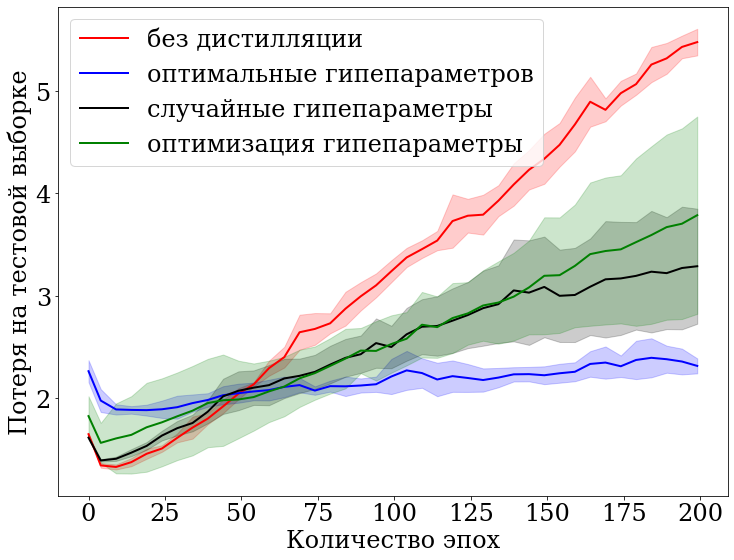

In [126]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
loss_b = np.array([subdata['results'][i]['test loss'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
plt.plot(epoch_b, loss_b.mean(1), '-', color='red', label='без дистилляции')
plt.fill_between(epoch_b, loss_b.mean(1)-loss_b.std(1), loss_b.mean(1)+loss_b.std(1), alpha=0.2, color='red')

epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
loss_d = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
plt.plot(epoch_d, loss_d.mean(1), '-', color='blue', label='оптимальные гипепараметров')
plt.fill_between(epoch_d, loss_d.mean(1)-loss_d.std(1), loss_d.mean(1)+loss_d.std(1), alpha=0.2, color='blue')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
loss_dr = np.array([subdata['results'][i]['test loss'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
plt.plot(epoch_dr, loss_dr.mean(1), '-', color='black', label='случайные гипепараметры')
plt.fill_between(epoch_dr, loss_dr.mean(1)-loss_dr.std(1), loss_dr.mean(1)+loss_dr.std(1), alpha=0.2, color='black')


epoch_h = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
loss_h = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_h, loss_h.mean(1), '-', color='green', label='оптимизация гипепараметры')
plt.fill_between(epoch_h, loss_h.mean(1)-loss_h.std(1), loss_h.mean(1)+loss_h.std(1), alpha=0.2, color='green')

plt.xlabel('Количество эпох')
plt.ylabel('Потеря на тестовой выборке')

plt.legend()
plt.savefig('loss.pdf')

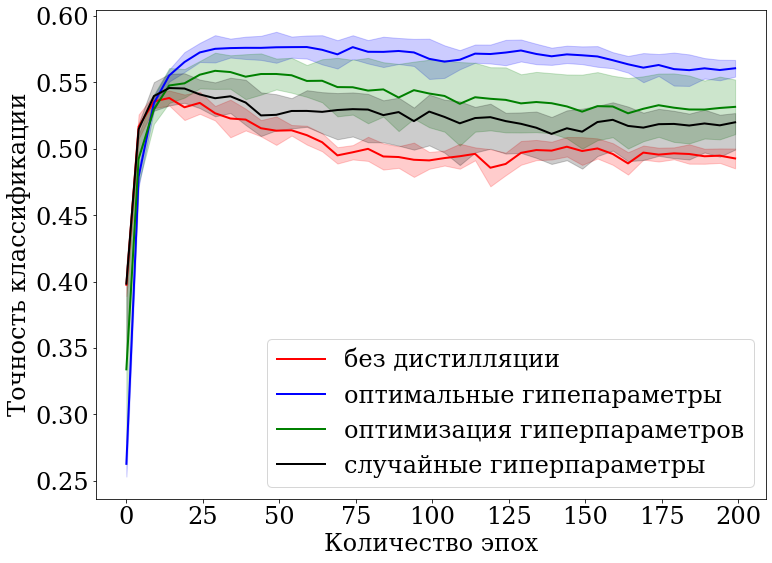

In [60]:
epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
acc_b = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
plt.plot(epoch_b, acc_b.mean(1), '-', color='red', label='без дистилляции')
plt.fill_between(epoch_b, acc_b.mean(1)-acc_b.std(1), acc_b.mean(1)+acc_b.std(1), alpha=0.2, color='red')

epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
acc_d = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
plt.plot(epoch_d, acc_d.mean(1), '-', color='blue', label='оптимальные гипепараметры')
plt.fill_between(epoch_d, acc_d.mean(1)-acc_d.std(1), acc_d.mean(1)+acc_d.std(1), alpha=0.2, color='blue')

epoch_h = np.array([data_h[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
acc_h = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_d[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_h, acc_h.mean(1), '-', color='green', label='оптимизация гиперпараметров')
plt.fill_between(epoch_h, acc_h.mean(1)-acc_h.std(1), acc_h.mean(1)+acc_h.std(1), alpha=0.2, color='green')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
acc_dr = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_dr, acc_dr.mean(1), '-', color='black', label='случайные гиперпараметры')
plt.fill_between(epoch_dr, acc_dr.mean(1)-acc_h.std(1), acc_dr.mean(1)+acc_dr.std(1), alpha=0.2, color='black')


plt.xlabel('Количество эпох')
plt.ylabel('Точность классификации')
plt.legend()
plt.savefig('acc.pdf')

In [48]:
epoch_b = np.hstack((epoch_b, epoch_b, epoch_b, epoch_b, epoch_b))

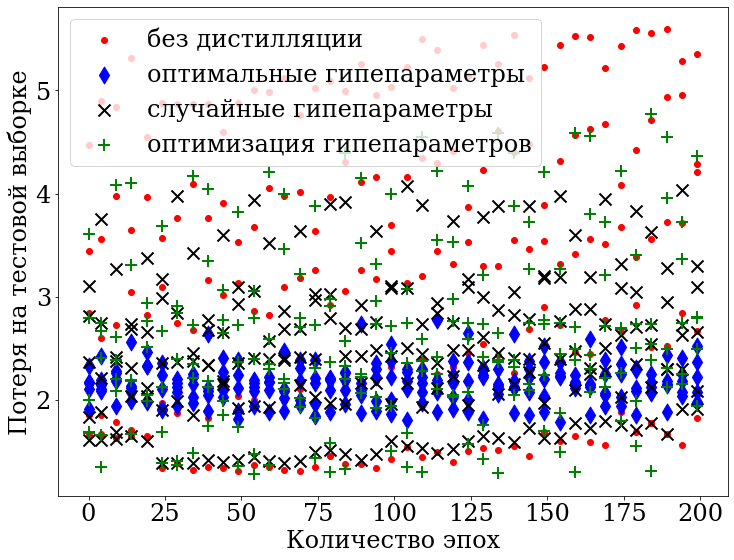

In [90]:
epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
epoch_b.reshape(41, 1)
epoch_b = np.hstack((epoch_b, epoch_b, epoch_b, epoch_b, epoch_b))
loss_b = np.array([subdata['results'][i]['test loss'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
plt.scatter(epoch_b, loss_b, color='red', marker='.', label='без дистилляции')
#plt.fill_between(epoch_b, loss_b.mean(1)-loss_b.std(1), loss_b.mean(1)+loss_b.std(1), alpha=0.2, color='red')

epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
epoch_d.reshape(41, 1)
epoch_d = np.hstack((epoch_d, epoch_d, epoch_d, epoch_d, epoch_d))
loss_d = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
plt.scatter(epoch_d, loss_d, marker='d', color='blue', label='оптимальные гипепараметры')
#plt.fill_between(epoch_d, loss_d.mean(1)-loss_d.std(1), loss_d.mean(1)+loss_d.std(1), alpha=0.2, color='blue')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
epoch_dr.reshape(41, 1)
epoch_dr = np.hstack((epoch_dr, epoch_dr, epoch_dr, epoch_dr, epoch_dr))
loss_dr = np.array([subdata['results'][i]['test loss'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
plt.scatter(epoch_dr, loss_dr, marker='x', color='black', label='случайные гипепараметры')
#plt.fill_between(epoch_dr, loss_dr.mean(1)-loss_dr.std(1), loss_dr.mean(1)+loss_dr.std(1), alpha=0.2, color='black')


epoch_h = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
epoch_h.reshape(41, 1)
epoch_h = np.hstack((epoch_h, epoch_h, epoch_h, epoch_h, epoch_h))
loss_h = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.scatter(epoch_h, loss_h, marker='+', color='green', label='оптимизация гипепараметров')
#plt.fill_between(epoch_h, loss_h.mean(1)-loss_h.std(1), loss_h.mean(1)+loss_h.std(1), alpha=0.2, color='green')

plt.xlabel('Количество эпох')
plt.ylabel('Потеря на тестовой выборке')
plt.legend()
plt.savefig('scatter_plot_loss.pdf')

In [46]:
epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
beta_d = np.array([data_d[2]['results'][i]['beta'] for i in range(len(data_d[2]['results']))])
plt.plot(epoch_d, beta_d, '-', color='blue', label='дистилляция без оптимизации гипепараметров')
plt.fill_between(epoch_d, beta_d-beta_d.std(), beta_d+beta_d.std(), alpha=0.2, color='blue')

epoch_h = np.array([data_h[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
beta_h = np.array([data_h[2]['results'][i]['beta'] for i in range(len(data_h[2]['results']))])
plt.plot(epoch_h, beta_h, '-', color='green', label='дистилляция с оптимизацией гипепараметров')
plt.fill_between(epoch_h, beta_h-beta_h.std(), beta_h+beta_h.std(), alpha=0.2, color='green')

plt.legend()
plt.savefig('3.eps')

KeyError: 'beta'

In [47]:
epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
temp_d = np.array([data_d[2]['results'][i]['temp'] for i in range(len(data_d[2]['results']))])
plt.plot(epoch_d, temp_d, '-', color='blue', label='дистилляция без оптимизации гипепараметров')
plt.fill_between(epoch_d, temp_d-temp_d.std(), temp_d+temp_d.std(), alpha=0.2, color='blue')

epoch_h = np.array([data_h[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
temp_h = np.array([data_h[2]['results'][i]['temp'] for i in range(len(data_h[2]['results']))])
plt.plot(epoch_h, temp_h, '-', color='green', label='дистилляция с оптимизацией гипепараметров')
plt.fill_between(temp_h, temp_h-temp_h.std(), temp_h+temp_h.std(), alpha=0.2, color='green')

plt.legend()
plt.savefig('4.eps')

KeyError: 'temp'

In [79]:
l[0]

array([-0.53249779, -0.52740013, -0.53271023, -0.59983002, -0.51911631])

In [78]:
cm.seismic(l[0])

array([[0. , 0. , 0.3, 1. ],
       [0. , 0. , 0.3, 1. ],
       [0. , 0. , 0.3, 1. ],
       [0. , 0. , 0.3, 1. ],
       [0. , 0. , 0.3, 1. ]])

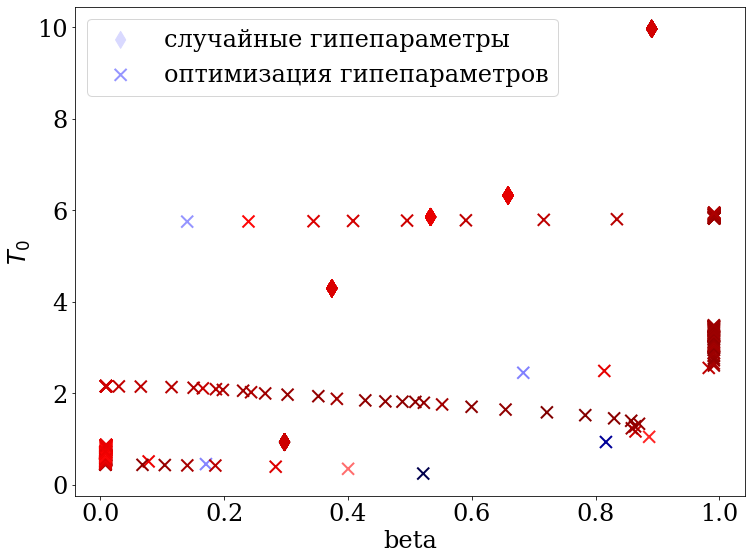

In [89]:
acc_dr = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
acc_h = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_h[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
all_results = list(acc_dr) + list(acc_h)
max_ = np.max(all_results)
min_ = np.min(all_results)

colors = [cm.seismic((r-min_)/(max_-min_)) for r in acc_dr.flatten()]
temp_dr = np.array([subdata['results'][i]['temp'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
beta_dr = np.array([subdata['results'][i]['beta'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
plt.scatter(beta_dr.flatten(), temp_dr.flatten(), marker='d', c=colors, label='случайные гипепараметры')

colors = [cm.seismic((r-min_)/(max_-min_)) for r in acc_h.flatten()]
temp_h = np.array([subdata['results'][i]['temp'] for i in range(len(data_h[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
beta_h = np.array([subdata['results'][i]['beta'] for i in range(len(data_h[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.scatter(beta_h, temp_h, marker='x', c=colors, label='оптимизация гипепараметров')

plt.xlabel('beta')
plt.ylabel('$T_0$')
plt.legend()
plt.savefig('scatter_plot_beta_temp.pdf')

In [87]:
max_

1.1244999766349792

In [ ]:
"""
посмотреть, куда сходятся гиперпараметры.
Задача скорее всего невыпуклая по гиперпараметрам, поэтому может быть несколько точек экстремума.

Взять одно, наилучшее значение гиперпараметров.

Посчитать дистилляцию БЕЗ оптимизации гиперпараметров с наилушчими значениями.

НЕ ЗАБУДЬ ПОМЕНЯТЬ ИМЯ ФАЙЛА ДЛЯ СОХРАНЕНИЯ
"""

In [ ]:
"""
Посчитать дистилляцию с оптимизацей гиперпараметров, в качестве начальной точки взять не случайные значения,
а start_beta, start_temp.

НЕ ЗАБУДЬ ПОМЕНЯТЬ ИМЯ ФАЙЛА ДЛЯ СОХРАНЕНИЯ
"""

In [ ]:
"""
Построить график функции потерь на тесте в зависимости от эпохи. 
На графике должны быть линии для :
    - оптимизации без дистилляции
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют start_temp, start_beta
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют оптимизированным значениям гиперпараметров
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение соответсвуeт start_temp, start_beta
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение случайное
"""

In [ ]:
"""
Построить график точности на тесте в зависимости от эпохи. 
На графике должны быть линии для :
    - оптимизации без дистилляции
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют start_temp, start_beta
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют оптимизированным значениям гиперпараметров
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение соответсвуeт start_temp, start_beta
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение случайное
"""

In [ ]:
"""
Построить график беты в зависимости от эпохи. 
На графике должны быть линии для :    
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют start_temp, start_beta
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют оптимизированным значениям гиперпараметров
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение соответсвуeт start_temp, start_beta
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение случайное
"""

In [ ]:
"""
Построить график температуры в зависимости от эпохи. 
На графике должны быть линии для :    
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют start_temp, start_beta
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют оптимизированным значениям гиперпараметров
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение соответсвуeт start_temp, start_beta
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение случайное
"""